# About

This notebook is the follow up to the `Tutorial 1: Data Import, Labeling, and Export` notebook. 

It will mainly cover the training, validation, and testing of statistical inference (i.e., machine learning) models. The goal is to create supervised regression models that can predict the concentration and identity of neurotransmitters from a set of unknown voltammograms, having been trained on a data set of known voltammograms. 

We will start with PCR and PLSR models, as these are the most common in the fast neurochemical voltammetry field. Since these two model types have many similarities, we'll use helper functions common between them.

The user should be familiar with how machine learning models such as these are used for voltammetry data. We cover only how to implement these models.

# Importing and Labeling

To make this notebook cleaner, we're going to list all our import packages and define all our helper functions in a separate notebook called `myFunctions_dev`. That way, we can simply import this notebook here once, and have everything defined in a single line of code.

To import this notebook, just make sure it is in the same file location as the notebook you are trying to import it into.

In [1]:
from ipynb.fs.full.myFunctions_dev import *

Let's go ahead and import and label our data. This process is largely the same as in `Tutorial 1`, see that notebook for more details. A few key differences will be noted here. But note how using the separate `myFunctions_dev` notebook, this is all done in only a couple lines of code.

We start by defining our analyte list and color coding. We'll also define what type of model we want to build (here, partial least squares regression, or PLSR).

In [2]:
analyte_list=['DA','HT']
cmap = {'DA':'r','HT':'b'}
modelChoice = 'PLSR'

A key difference here is that we will define a training set and a test set. Note the difference in the variables assigned to the file name in the cells below (e.g., train versus test).

The training set contains samples A-P in alphabetical order, with some blank samples (denoted 0) mixed in. In total, we have 20 training samples. Instead of extracting just one voltammogram per injection, we extracted 51 voltammograms per injection. This was done in SeroWare SeroDataProcess (see www.github.com/csmova/seroware/wiki for more information). Because we performed flow cell injections that were 20 seconds long, we took the last 5 seconds of the injection (where the signal is most stable). At a sampling speed of 1 MHz, this results in 51 voltammograms per injection, meaning 1020 voltammograms total.

We're also going to include some background signal voltammograms, i.e., voltammograms obtained not during an actual injection, but just while buffer is flowing through the flow cell in between injections. This helps account for noise and drift outside of the `0` samples, which account for injection noise. We've found that including these samples great helps with accuracy and drift correction. You can try for your own data and see if it helps. Let us know!

We'll extract the 5 seconds before each injection (only for the training set!) and label them as `0bs` for a blank of the background signal. Because we'll do this for every sample, it will double all training data size to 2040.

This is shown below. The `0bs` samples are highlighted in yellow. The other samples (`A`, `B`,...) are shown in blue. Both represent roughly ~5s of data.

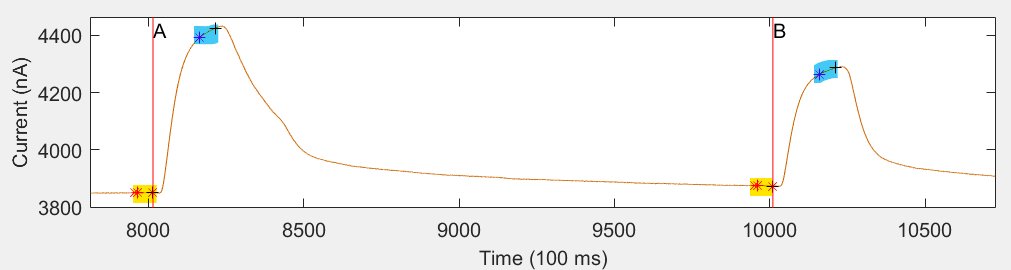

In [3]:
X_train, train_labels = import_data("./demo/r1s1wf6_02152023_train_0bs.mat",
                                   analyte_list)

remove_delimiter(X_train)

Again, try to give descriptive file names. Here, we denote the file as {waveform}\_{date}\_{train or test set data}\_{whether or not it includes 0bs samples}.

You could also include the electrode length, who performed the experiment, etc. Regardless, all metadata should be included along with the data in some format, even if not in the file name.

In [4]:
X_train.head

<bound method NDFrame.head of                0           0           0           0           0           0  \
0    -303.193704 -302.549088 -303.193704 -303.193704 -303.516013 -302.871396   
1    -303.193704 -303.193704 -303.193704 -303.516013 -302.871396 -303.193704   
2    -303.193704 -303.516013 -303.193704 -302.871396 -302.871396 -303.838321   
3    -302.549088 -302.549088 -302.871396 -303.516013 -303.193704 -302.871396   
4    -303.193704 -302.871396 -303.193704 -303.516013 -303.193704 -302.226779   
...          ...         ...         ...         ...         ...         ...   
5795 -383.126197 -383.448505 -383.126197 -382.803888 -383.448505 -383.770814   
5796 -383.126197 -383.770814 -383.770814 -382.803888 -383.126197 -384.093122   
5797 -383.126197 -382.803888 -383.448505 -383.770814 -383.448505 -383.448505   
5798 -382.803888 -383.126197 -383.448505 -382.481580 -383.126197 -383.126197   
5799 -382.803888 -383.126197 -382.481580 -383.126197 -383.126197 -383.448505   

         

Meanwhile, the test set contains four samples denoted with a T (for Test): `T1`, `T2`, `T3`, `T4`, along with a `0`. None of this samples will be included in the training set. This `X_test` set is only used for testing or evaluating the final model (trained on `X_train`). Because it contains 5 injections, each with 51 voltammgrams, we have 255 voltammograms total (columns). We don't need to include any `0bs` for the test set, unless we want to.

In [5]:
X_test, test_labels = import_data("./demo/r1s1wf6_02152023_test.mat",
                                   analyte_list)

remove_delimiter(X_test)

In [6]:
X_test.head

<bound method NDFrame.head of               T1          T1          T1          T1          T1          T1  \
0    -302.549088 -302.871396 -302.871396 -303.193704 -303.516013 -302.871396   
1    -302.549088 -303.193704 -302.549088 -302.549088 -302.549088 -302.871396   
2    -302.871396 -302.871396 -302.871396 -303.838321 -302.871396 -303.516013   
3    -302.871396 -303.193704 -303.516013 -302.871396 -302.871396 -303.193704   
4    -302.549088 -302.871396 -303.193704 -302.226779 -302.871396 -303.516013   
...          ...         ...         ...         ...         ...         ...   
5795 -382.803888 -382.803888 -382.803888 -382.481580 -382.481580 -383.126197   
5796 -383.126197 -382.481580 -382.803888 -383.126197 -382.481580 -382.481580   
5797 -382.803888 -382.481580 -382.803888 -382.481580 -382.159271 -382.481580   
5798 -382.481580 -381.836963 -382.481580 -382.803888 -381.836963 -382.481580   
5799 -382.803888 -382.481580 -382.803888 -383.126197 -382.481580 -382.159271   

         

Occasionally, you may wish to downsample your data for quicker training or memory restrictions. We can do this using the `downsample` helper function. We will not use this here, but some users may find this useful. E.g., to downsample by 10% (every tenth value):

In [7]:
#X_train = downsample(X_train,10)
#print(X_train.head)
#X_test = downsample(X_test,10)
#print(X_test.head)

The remaining steps are similar to the first notebook, with the only difference between that `y_train` and `y_test` labels need separate variables to correspond with `X_train` and `X_test`, respectively. Note, if you are including 0bs samples, make sure to add `0bs` as a `Std ID` to your schema, along with all concnetrations set to 0.

In [8]:
schema = create_schema_from_excel("./demo/RPV_standards_schema.xlsx",
                                  'standardset03302022')

In [9]:
y_train = label_concentrations(schema,analyte_list,train_labels)

In [10]:
y_test = label_concentrations(schema,analyte_list,test_labels)

As expected, our training and test set labels correspond to the number of voltammograms. 

In [11]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(y_train)
    print('---------------------------')
    print(y_test)

                 DA     HT
peak_labels               
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0

In just a couple blocks of code, we've imported and labeled all our data. We can plot all our voltammograms quickly using another helper function, `plot_raw_voltammograms`. Note- the more data you have, the longer this will take!

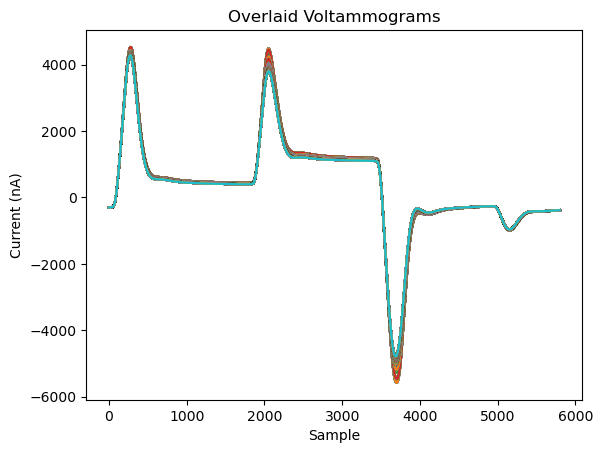

In [12]:
plot_raw_voltammograms(X_train)

# Pre-processing and Outlier Removal

Let's plot our data using various common pre-processing methods, such as standardization, normalization, and differentiation. This helps get an idea of the spread of our data, and specifically, helps catch outliers.

An important consideration: we do not cover how to background subtract, digitally filter, or perform other user-specific data processing protocols here, for the time being. Ideally, these processes should have occured prior to importing your data into Python. For example, the SeroWare SeroDataProcess module enables background subtraction, digital signal processing, signal averaging, and more. This notebook and database seeks to strike the right balance between processed data versus usable data. If your data has been processed in any way prior to import, this should always be noted!

Here, our data is as raw as possible, having only been extracted using the time stamps from flow cell injections such that we can be sure the concentration labels are correct. No digital filtering, averaging, or background subtraction has been performed.

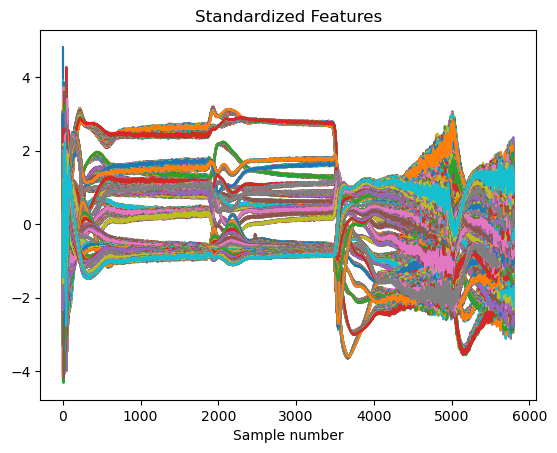

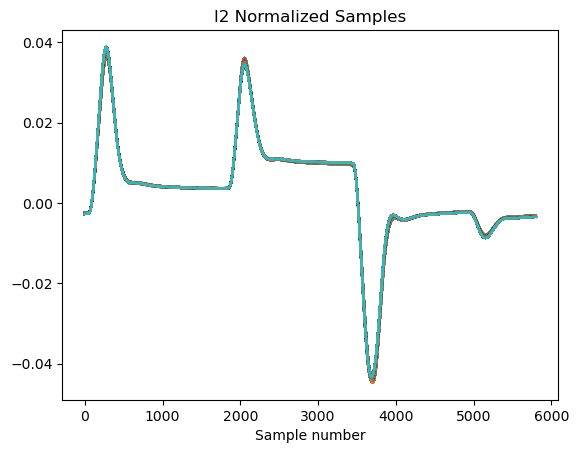

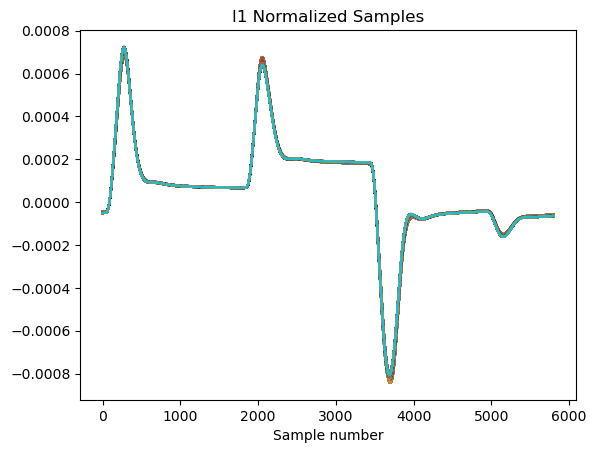

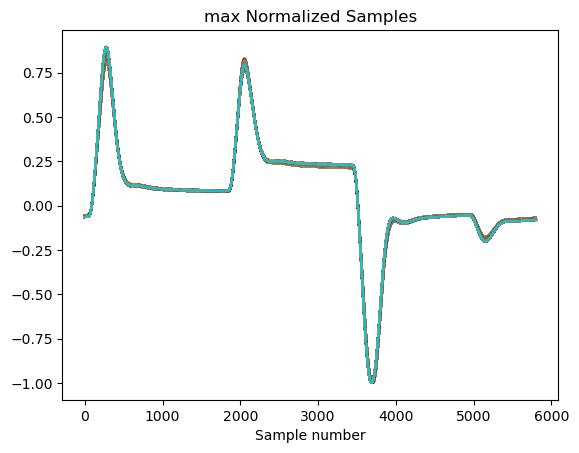

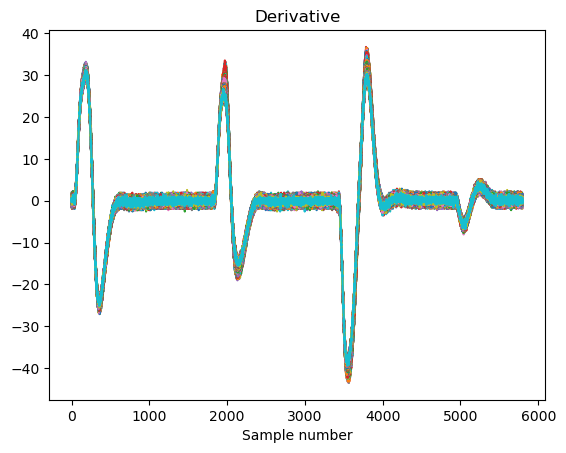

In [13]:
plot_preprocessers(X_train)

Another useful way to visualize the data, see the effects of pre-processing, and catch outliers is to run PCA. Our helper function will automatically plot various pre-processed data on the first two PCs, along with sample labels and colored points representing the various concentrations of that sample.

Note how the 0 and 0bs scores are clustered mainly in one quadrant/side of the axes.

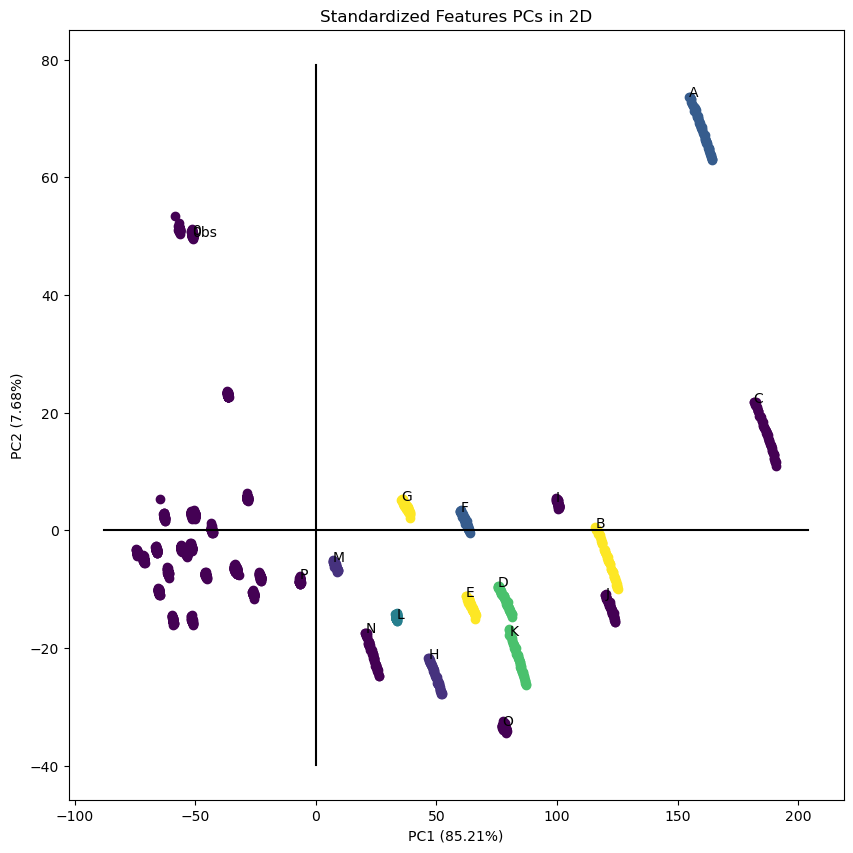

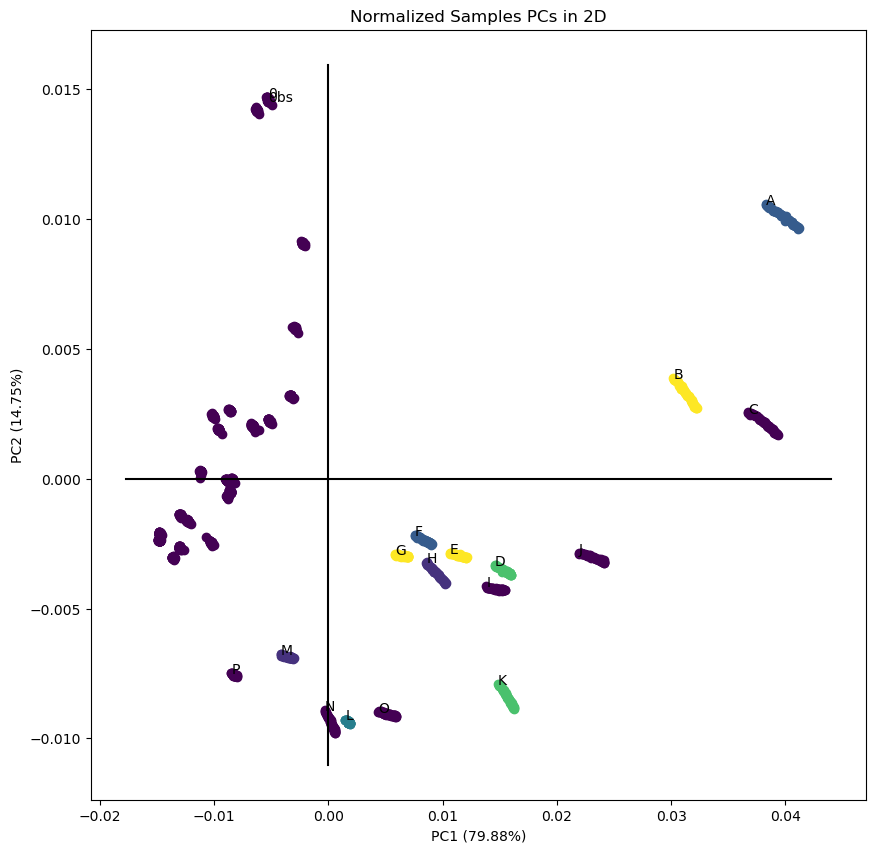

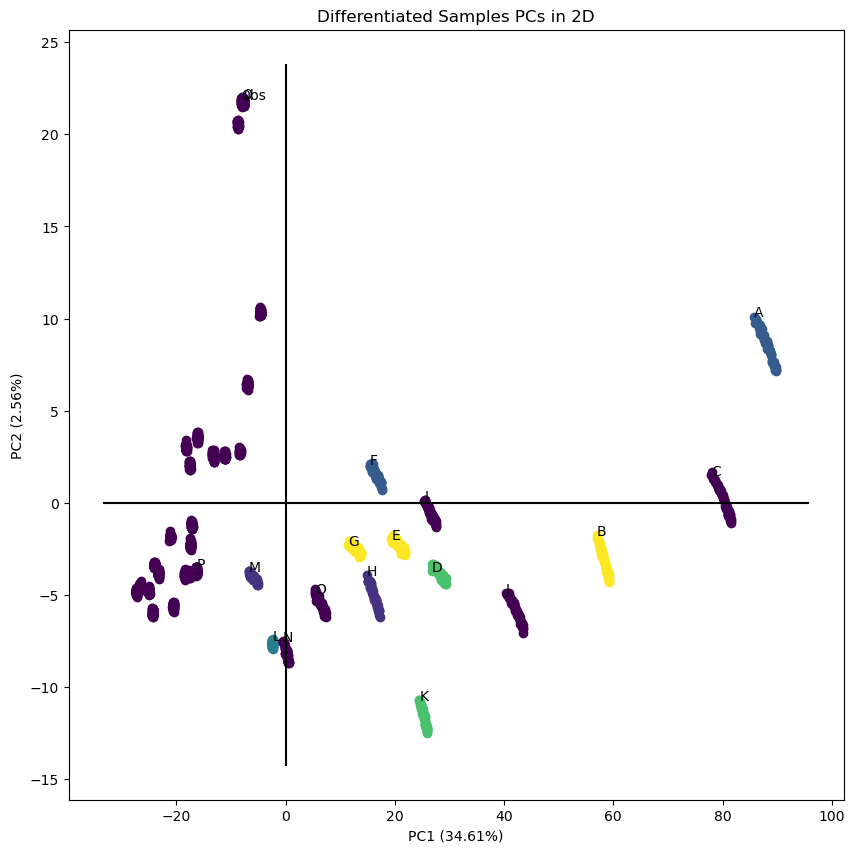

In [14]:
get_PCA(X_train,y_train,analyte_list)

Our data appears to be quite clean. We could perform other outlier tests as desired, such as SPE, Hotelling T2 test, and so forth. These are largely user-dependent. See: https://pypi.org/project/pca/ for some useful functionality. 

Looking at the standardized voltammograms usually catches outliers, especially ones caused by erroneous noise at a certain sampled point. This will cause a large change in the standard deviation of that point, and can be visually spotted by eye. 

A quick trick to identify and remove this voltammogram is given below. Instead of removing the outlier voltammogram, the voltammograms directly before and after it are averaged and used to replace that outlier. Just make sure it isnt a voltammogram that is the first or last in its sample, otherwise the voltammogram will be averaged from two different samples. We use this trick as it prevents sample imbalance when many outliers are present, helps average over noise, and provides a quick work around to having to also update the sample labels.

An example of some visually spotted outliers is shown below (not from this data set).

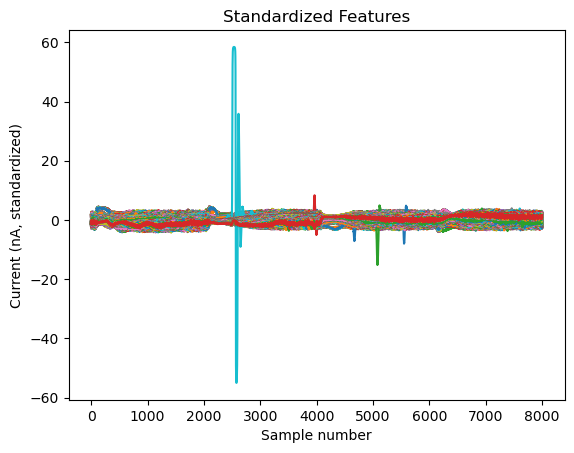

Using the following commands, a given number of samples with points having standard deviations that are outside a desired cut off (i.e., the turqiouse, red, 2 blue, and green abberations above; 5 total) can be averaged out. These single point abberations can occur due to experimental noise.

We won't actually run this code here because our data is clean, but this and other procedures that work well with your data to remove outliers should be used here.

In [15]:
#outlier_history=[]

In [16]:
#num_outliers=5

#for i in np.arange(num_outliers):
#    scaledX = pd.DataFrame(abs(scale(X_train.T).T))
#    with pd.option_context('display.max_rows', None,
#                           'display.max_columns', None,
#                           'display.precision', 3,
#                           ):
#        scaled_max = scaledX.max().max()
        #print(scaledX.idxmax(axis=1))

    # Calling getIndexes() function to get
    # the index positions of all occurrences
#    listOfPositions = getIndexes(scaledX,scaled_max)

    #print('Max std dev outlier found at : ')

    # Printing the position
    #for i in range(len(listOfPositions)):
        #print(listOfPositions[i])

#    plt.plot(scaledX.loc[:,listOfPositions[0][1]]);
#    plt.title("Outliers")
#    plt.xlabel("Sample Number")
#    plt.ylabel("Scaled Current (nA)")
    
#    outlier_history.append(listOfPositions[0][1])
#    X_train.iloc[:,listOfPositions[0][1]] = (X_train.iloc[:,listOfPositions[0][1]-1]+X_train.iloc[:,listOfPositions[0][1]+1])/2


#print('Outliers Identified: '+ str(outlier_history));
#plt.show()
#scaledX = pd.DataFrame(scale(X_train.T).T)
#plt.plot(scaledX);
#plt.title("Data with Outliers Removed")
#plt.xlabel("Sample Number")
#plt.ylabel("Scaled Current")
#plt.show()

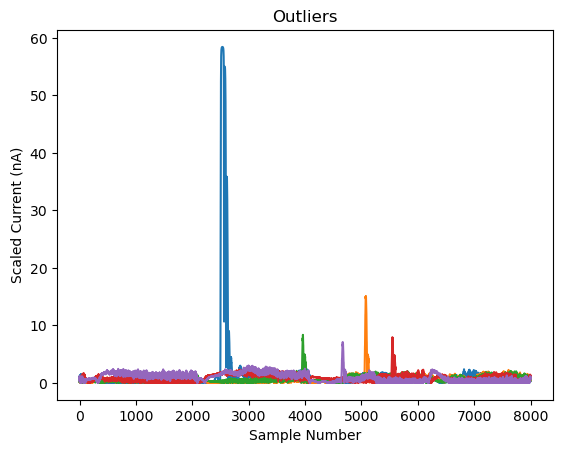

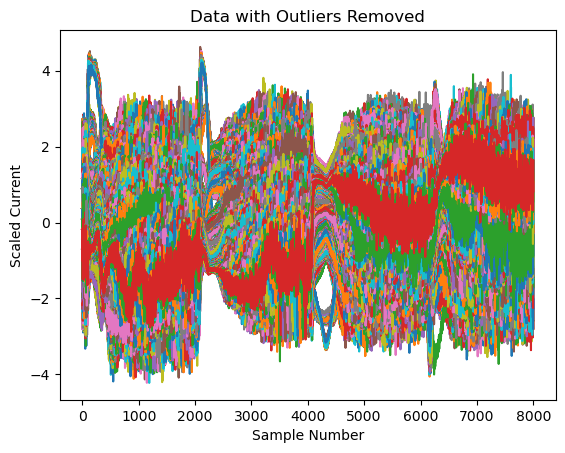

Now our data above is much cleaner. 

You can also drop samples directly from the data frames using the `drop` method. 

In [17]:
#samples_to_drop=[];
#y_train=y_train.drop([samples_to_drop])
#X_train=X_train.drop(columns=samples_to_drop)

# Model Selection

After exploring the various pre-processing effects and removing outliers, out data should be in the cleanest possible format. We now need to decide on a single pre-processing method to use for our model (we can always try multiple and compare, but the pre-processing must be consistent within that model!).

We've created a helper function to set your pre-process protocol. Note that pre-processers are `fit` to the training data, such that the pre-processing parameters can be applied to `transform` the unknown test data without data leakage. This is why it is important to keep your preprocessing procedures consistent.

Here, we are going to normalize our data, which requires setting the type of norm (here, `max`).

In [18]:
preprocesser = set_preprocess('Normalize Samples',X_train,myNorm='max')

The reason we set our preprocessor as a variable is so we can iincorporate into a sci-kit learn pipeline. This allows for consistency in modeling. For example, the below line of code fully trains a model of our choice (PLSR or PCR) on our data using our desired pre-processing. It returns how much of the variance in the data is explained by the model, broken down by the number of components (for example, 1-20 if we set `nComps = 20`). Although we could explore the thousands of components, usually by ~20, the variance explained levels off (and the model starts to overfit!), so its not worth the wasted computation time.

In [19]:
nComps = 20

     N        DA        HT
0    1  0.343539  0.152667
1    2  0.415754  0.249836
2    3   0.66866  0.381539
3    4  0.792527  0.395929
4    5  0.863871  0.512669
5    6  0.906188   0.63451
6    7  0.925724  0.634829
7    8  0.950052   0.69542
8    9  0.951952  0.929076
9   10  0.962416  0.929077
10  11  0.966262  0.929079
11  12  0.968856  0.938559
12  13  0.972143  0.938668
13  14  0.978741  0.938813
14  15  0.978742  0.955085
15  16  0.979344  0.956475
16  17  0.980846   0.95895
17  18  0.987118  0.958953
18  19  0.990775  0.960374
19  20  0.993203  0.960749


(array([[-26.63741926,  25.47264845],
        [ 37.0851607 ,  18.38128575],
        [  0.81597659,  19.18247575],
        ...,
        [-17.41438226, -30.89351822],
        [-33.58247553, -19.70206429],
        [  1.21748905, -14.10761659]]),
      N        DA        HT
 0    1  0.343539  0.152667
 1    2  0.415754  0.249836
 2    3   0.66866  0.381539
 3    4  0.792527  0.395929
 4    5  0.863871  0.512669
 5    6  0.906188   0.63451
 6    7  0.925724  0.634829
 7    8  0.950052   0.69542
 8    9  0.951952  0.929076
 9   10  0.962416  0.929077
 10  11  0.966262  0.929079
 11  12  0.968856  0.938559
 12  13  0.972143  0.938668
 13  14  0.978741  0.938813
 14  15  0.978742  0.955085
 15  16  0.979344  0.956475
 16  17  0.980846   0.95895
 17  18  0.987118  0.958953
 18  19  0.990775  0.960374
 19  20  0.993203  0.960749)

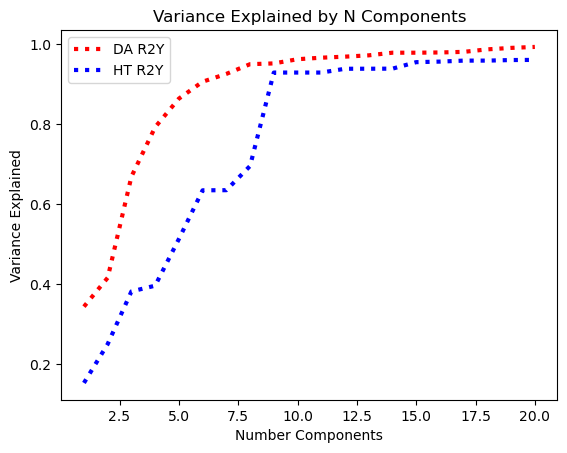

In [20]:
get_R2Y(nComps,X_train,y_train,analyte_list,modelChoice,preprocesser,cmap)

Similarly, we can look at the cross-validated variance explained. The default cross validation is 5-fold. This process can take quite a while depending on what you set `nComps` to, and the size of your dataset. 

     N        DA        HT
0    1  0.307065  0.110467
1    2    0.2544  0.009479
2    3  0.557957   0.15845
3    4  0.682331   0.08129
4    5  0.709856 -0.386019
5    6  0.787898 -0.306797
6    7  0.879698 -0.484222
7    8  0.863296  -0.28639
8    9  0.885394  0.411426
9   10   0.80305  0.558766
10  11  0.801551  0.615728
11  12   0.76725  0.564618
12  13  0.673062  0.600841
13  14  0.521795  0.616955
14  15   0.68118  0.648222
15  16  0.671889  0.630414
16  17  0.636767  0.646555
17  18  0.551326  0.679721
18  19  0.601483  0.662174
19  20  0.616736  0.645511


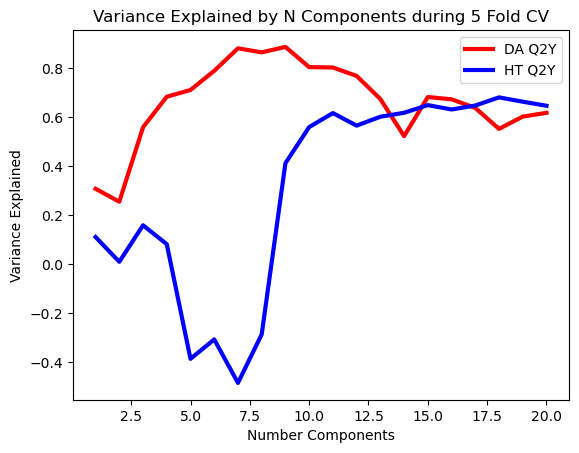

(array([[-46.78853241,  20.13919284],
        [ 11.17214573,   9.22006913],
        [-15.79664333,  12.57944649],
        ...,
        [ 39.51892444, -51.62776617],
        [ 24.69180699, -29.39549283],
        [ 51.79235625, -23.73715968]]),
      N        DA        HT
 0    1  0.307065  0.110467
 1    2    0.2544  0.009479
 2    3  0.557957   0.15845
 3    4  0.682331   0.08129
 4    5  0.709856 -0.386019
 5    6  0.787898 -0.306797
 6    7  0.879698 -0.484222
 7    8  0.863296  -0.28639
 8    9  0.885394  0.411426
 9   10   0.80305  0.558766
 10  11  0.801551  0.615728
 11  12   0.76725  0.564618
 12  13  0.673062  0.600841
 13  14  0.521795  0.616955
 14  15   0.68118  0.648222
 15  16  0.671889  0.630414
 16  17  0.636767  0.646555
 17  18  0.551326  0.679721
 18  19  0.601483  0.662174
 19  20  0.616736  0.645511)

In [22]:
get_Q2Y(nComps,X_train,y_train,analyte_list,modelChoice,preprocesser,cmap)

You can also use these functions to look over various pre-processing and/or visualize R2Y and Q2Y on the same plot. 

You can also train the models as single-analyte at a time to (PLS1; below) rather than multi-target (PLS2; above). See: https://scikit-learn.org/stable/modules/cross_decomposition.html#cross-decomposition

For example:

Normalize Samples max
     N        DA
0    1  0.340239
1    2  0.419841
2    3  0.703264
3    4  0.801191
4    5  0.893696
5    6  0.923672
6    7  0.941585
7    8  0.955334
8    9  0.962884
9   10  0.966309
10  11  0.971376
11  12  0.972367
12  13  0.977456
13  14  0.979093
14  15  0.981653
15  16  0.986096
16  17  0.988753
17  18   0.99168
18  19  0.992661
19  20  0.994357
     N        DA
0    1  0.302636
1    2  0.252928
2    3  0.598158
3    4  0.687581
4    5  0.782975
5    6    0.8747
6    7  0.900294
7    8  0.872088
8    9  0.804633
9   10  0.794591
10  11  0.742775
11  12   0.65341
12  13  0.534837
13  14  0.615667
14  15  0.684088
15  16  0.644563
16  17  0.589164
17  18  0.569331
18  19  0.622045
19  20  0.636364


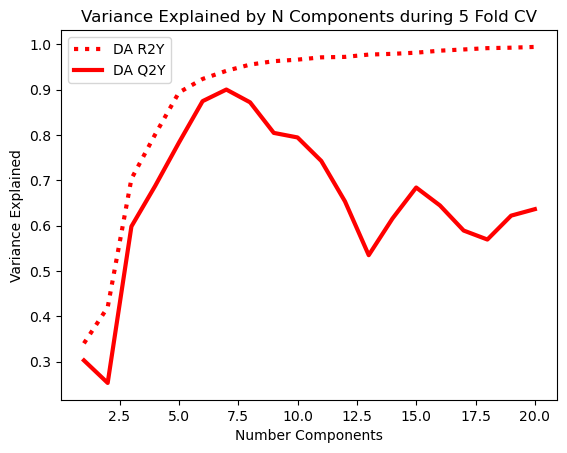

Normalize Samples max
     N        HT
0    1   0.19186
1    2  0.267809
2    3  0.489584
3    4  0.622374
4    5   0.65342
5    6  0.807249
6    7  0.853957
7    8  0.920034
8    9  0.928474
9   10  0.932497
10  11   0.94165
11  12  0.950926
12  13  0.954123
13  14  0.958946
14  15  0.963627
15  16  0.969719
16  17  0.973637
17  18  0.980434
18  19  0.986262
19  20  0.990289
     N        HT
0    1  0.118229
1    2  0.004709
2    3  0.054863
3    4   0.03711
4    5 -0.355895
5    6 -0.524936
6    7 -0.017862
7    8  0.453052
8    9  0.533605
9   10  0.577386
10  11  0.622056
11  12  0.623269
12  13  0.633338
13  14  0.662859
14  15  0.626973
15  16   0.63647
16  17  0.663037
17  18  0.692272
18  19  0.664289
19  20  0.665146


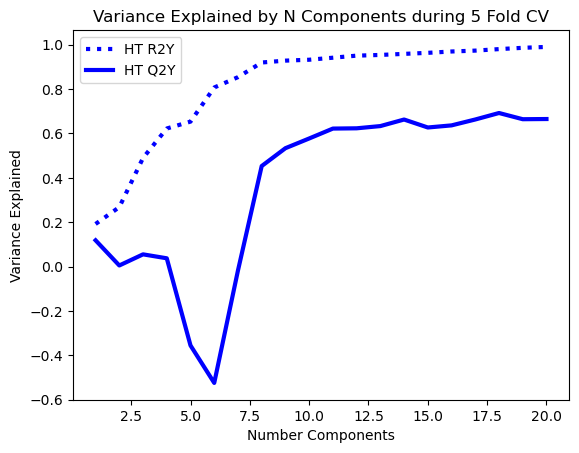

In [25]:
pps = ['Normalize Samples']
#pps = ['Normalize Samples','Scale Features',]

#nrms=['max','l1','l2']
nrms=['max']

#use only Normalize Max to save time

for analyte in analyte_list:
    for pp in pps:
        if pp == 'Normalize Samples':
            for nrm in nrms:
                preprocesser = set_preprocess(pp,X_train,myNorm=nrm)
                print(pp,nrm)
                get_R2Y(nComps,X_train,y_train[analyte],[analyte],modelChoice,preprocesser,cmap)
                get_Q2Y(nComps,X_train,y_train[analyte],[analyte],modelChoice,preprocesser,cmap)
                plt.show()
        else:
            preprocesser = set_preprocess(pp,X_train)
            print(pp)
            get_R2Y(nComps,X_train,y_train[analyte],[analyte],modelChoice,preprocesser,cmap)
            get_Q2Y(nComps,X_train,y_train[analyte],[analyte],modelChoice,preprocesser,cmap)
            plt.show()

Let's focus just on Normalize Max pre-processed data (empirically, this works better or about the same for our data as other preprocessers).

The advantage of using single-target models is you can optimize the number of components per analyte. The downside is you now have multiple models. Empirically, the results are similar from what we have seen on our data.

Based on the elbow point of the R2Y and Q2Y plots, we should choose ~7 components for DA and ~12 components for HT.

Now we can set our final model as such. For brevity, rather than train 2 separate models, we'll  just train a single model and use 12 components.

In [26]:
finalComps = 12

In [27]:
model = set_model(modelChoice,X_train.T,y_train,finalComps,preprocesser)

                 DA                  HT
0  0.97874163173255                 NaN
1               NaN  0.9550854361745875


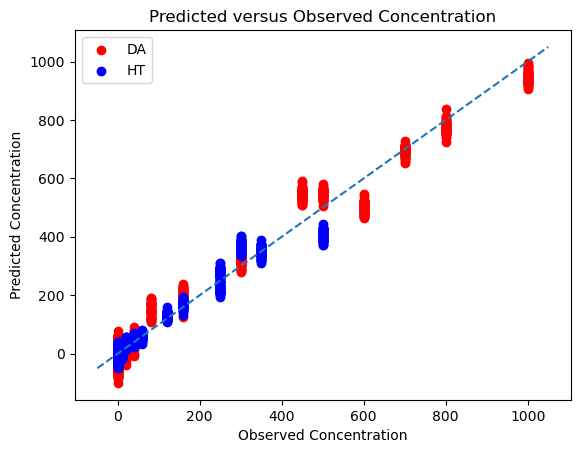

In [28]:
calibration_curves(model,X_train.T,y_train,analyte_list,cmap)

There are many other cross-validation approaches to explore besides k-fold. For example, you can leave-one-out, leave-one-group-out, perform repeated k-fold, etc. See https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

Here is an example of Leave One Group Out (LOGO), where groups are conncentration levels of a given analyte.

Let's compare 5-fold CV to LOGO since choosing the number of components can be a bit ambigious (i.e., deciding exactly where the elbow point is can be difficult).

Let's plot the results from 5 to 18 components as this was the biggest range of change for 5-fold CV.

Num comps is 6
R2=0.5989852742721602
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0      218.120430         0.0   236.456458
1       -6.894357        20.0    22.219186
2      133.114238        40.0    26.400760
3      253.963199        80.0    16.145758
4      131.676255       160.0    10.345213
5      486.906666       300.0     9.633827
6      647.364077       450.0     6.524318
7      623.715527       500.0     6.942515
8      440.040913       600.0     6.147629
9      545.152566       700.0     6.007026
10     682.622455       800.0    16.925296
11     776.304661      1000.0    13.470326


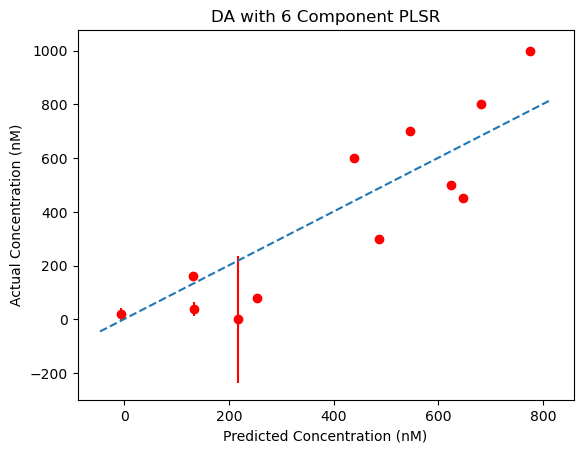

Num comps is 7
R2=0.6476760360070992
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0     -167.748643         0.0   176.306326
1       43.494014        20.0    14.666024
2       57.284407        40.0    18.773775
3      286.890429        80.0    13.985981
4      213.533501       160.0     8.252979
5      574.079596       300.0     6.307229
6      646.060318       450.0     8.589259
7      637.226621       500.0     6.619814
8      483.534442       600.0     5.780792
9      632.295794       700.0     5.893069
10     609.776701       800.0    14.908899
11     718.136243      1000.0     7.622308


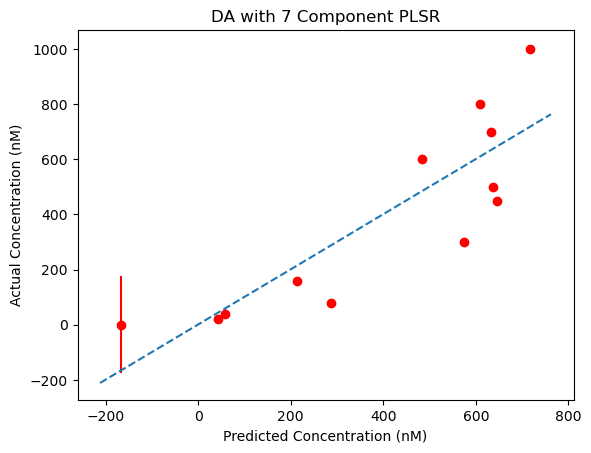

Num comps is 8
R2=0.673819216816306
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0     -437.846399         0.0   103.532929
1       23.429536        20.0    11.080252
2      124.595927        40.0    15.383100
3      381.376384        80.0    12.134758
4      219.580278       160.0     7.269257
5      502.053889       300.0     5.775937
6      585.952116       450.0     9.191808
7      591.617331       500.0     6.715122
8      463.984189       600.0     5.289293
9      663.073210       700.0     6.538363
10     655.057709       800.0    13.909186
11     812.890138      1000.0     6.402386


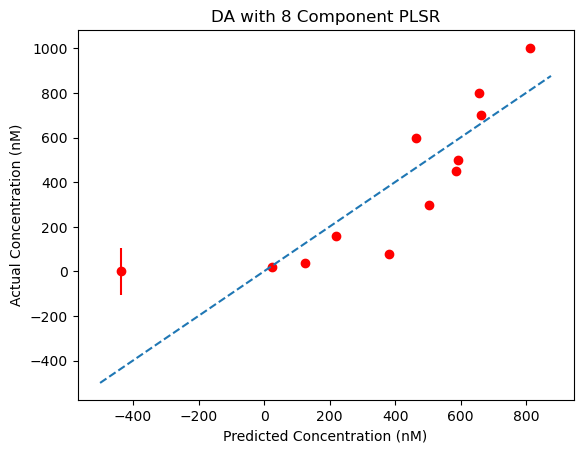

Num comps is 9
R2=0.6081607512242342
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0     -730.964072         0.0   199.446379
1      -35.894223        20.0    10.338698
2       65.874401        40.0    19.724342
3      377.856116        80.0    18.108346
4      195.424252       160.0     9.004681
5      507.534265       300.0    16.409502
6      607.011860       450.0    14.531127
7      656.211357       500.0     8.319712
8      476.810365       600.0     6.631844
9      647.393334       700.0     6.999348
10     647.501213       800.0    22.517290
11     822.470249      1000.0    15.351626


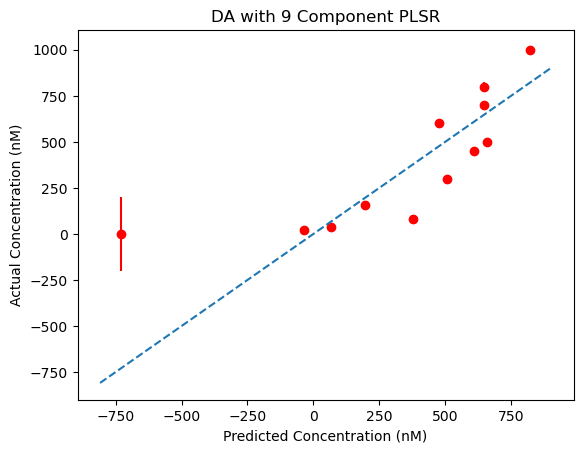

Num comps is 10
R2=0.5743966227972889
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0     -850.468054         0.0   401.816756
1      -33.596103        20.0     6.207723
2       -9.718140        40.0     8.742683
3      362.063095        80.0    14.624894
4      224.010455       160.0     8.652004
5      536.082533       300.0     6.521450
6      627.678926       450.0     8.897690
7      665.335836       500.0     7.419848
8      439.975105       600.0    10.791672
9      683.082259       700.0     8.013423
10     678.813639       800.0    16.518983
11     796.366174      1000.0     7.391394


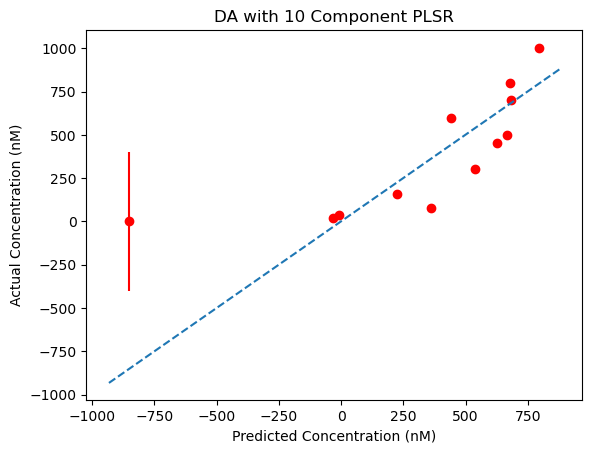

Num comps is 11
R2=0.5213833123207732
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0     -923.134731         0.0   396.228893
1      -10.902981        20.0    12.391994
2      -32.793624        40.0     9.504370
3      372.294024        80.0    14.877802
4      217.300848       160.0    11.121090
5      606.705470       300.0     8.714978
6      666.046239       450.0    16.527388
7      712.237274       500.0    10.074449
8      429.623683       600.0    10.145544
9      724.977625       700.0     7.635518
10     664.664537       800.0    22.082438
11     738.849400      1000.0    12.201052


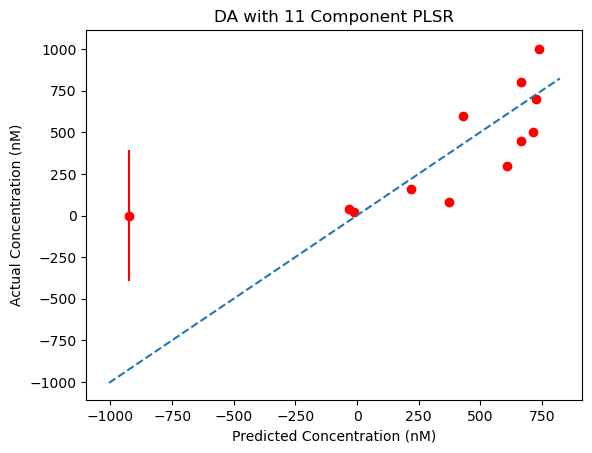

Num comps is 12
R2=0.4697691183598909
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0    -1037.418153         0.0   355.590694
1       20.391894        20.0    13.629505
2       24.694096        40.0    16.419229
3      418.155590        80.0    18.522858
4      221.273473       160.0    12.160442
5      684.843172       300.0    10.236779
6      660.071098       450.0    16.827214
7      735.717319       500.0    10.682187
8      446.978634       600.0    11.213616
9      689.411319       700.0     9.080320
10     668.992774       800.0    21.523714
11     756.644699      1000.0    13.731830


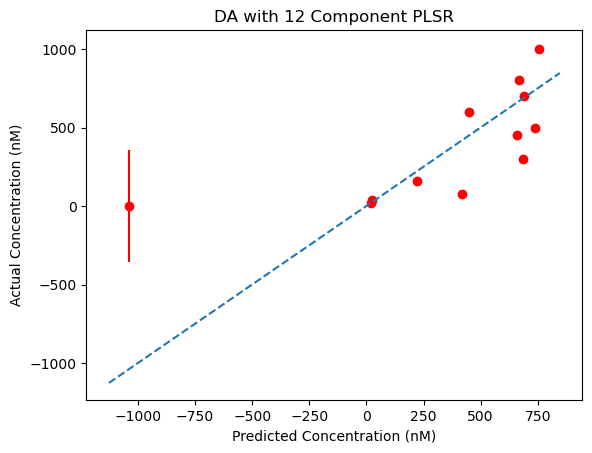

Num comps is 13
R2=0.4582354908983294
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0    -1091.785346         0.0   389.424705
1       -9.932124        20.0    18.423715
2       40.400474        40.0    18.658594
3      410.410076        80.0    18.955459
4      242.566536       160.0    22.922772
5      666.339406       300.0    15.203886
6      653.004180       450.0    18.101131
7      683.666352       500.0    11.610394
8      428.861053       600.0    18.326212
9      679.801897       700.0    16.898885
10     687.461183       800.0    17.017746
11     741.058187      1000.0    15.558390


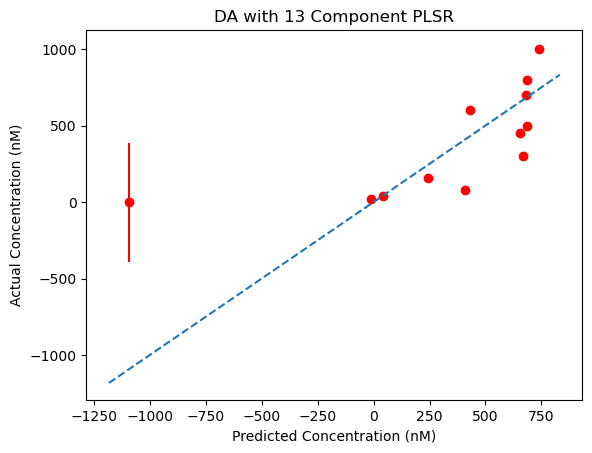

Num comps is 14
R2=0.43845251412074804
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0    -1099.272089         0.0   386.040059
1      -15.583126        20.0    18.752677
2       29.691422        40.0    18.711388
3      371.458854        80.0    22.364003
4      246.918807       160.0    23.075900
5      760.145017       300.0    16.329664
6      653.758044       450.0    18.918809
7      733.043354       500.0    15.578229
8      423.528366       600.0    23.098781
9      673.421444       700.0    17.435152
10     671.703431       800.0    18.091716
11     712.663660      1000.0    18.191554


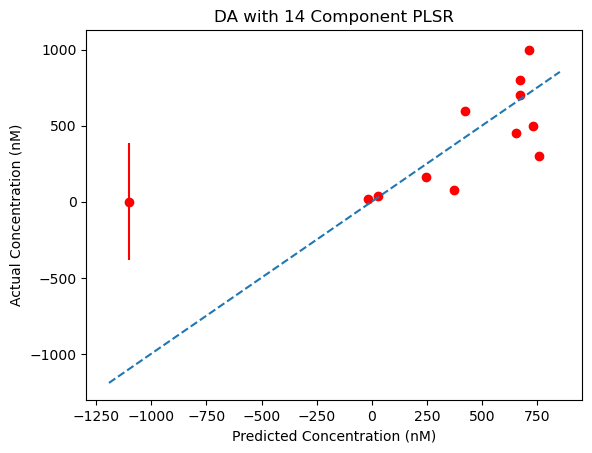

Num comps is 15
R2=0.46810681042480706
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0    -1027.109121         0.0   357.662807
1      -41.009155        20.0    20.844439
2       31.170862        40.0    21.823513
3      378.771269        80.0    22.273572
4      240.534426       160.0    22.778323
5      740.044068       300.0    18.884908
6      644.959093       450.0    20.820458
7      717.675160       500.0    16.856498
8      427.441369       600.0    21.365948
9      668.040801       700.0    15.642359
10     679.229051       800.0    19.094532
11     741.042536      1000.0    20.943957


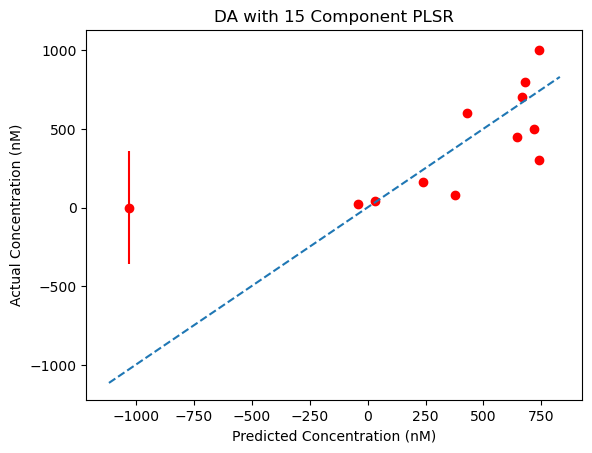

Num comps is 16
R2=0.49056808826216414
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0    -1013.899549         0.0   372.568754
1     -103.631786        20.0    21.163322
2       81.722401        40.0    22.498500
3      400.760392        80.0    25.078748
4      231.485113       160.0    26.886247
5      656.650792       300.0    21.421010
6      634.668188       450.0    19.868254
7      721.792319       500.0    19.423581
8      420.265757       600.0    23.242773
9      699.845200       700.0    21.603286
10     701.679016       800.0    18.846763
11     751.528822      1000.0    24.889521


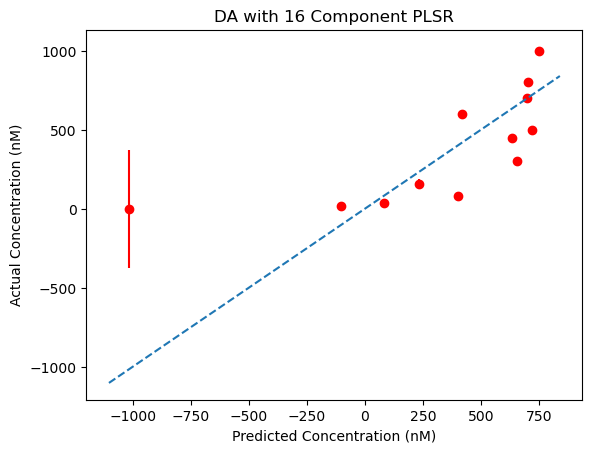

Num comps is 17
R2=0.4538382203337604
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0    -1017.589815         0.0   368.194720
1      -44.173152        20.0    22.619520
2       38.648213        40.0    22.847117
3      399.842348        80.0    25.353476
4      251.325794       160.0    25.830604
5      754.608856       300.0    21.826903
6      635.622359       450.0    19.061011
7      739.934159       500.0    20.485194
8      407.712806       600.0    23.198730
9      706.441069       700.0    22.143870
10     659.515805       800.0    22.834283
11     723.068526      1000.0    20.174939


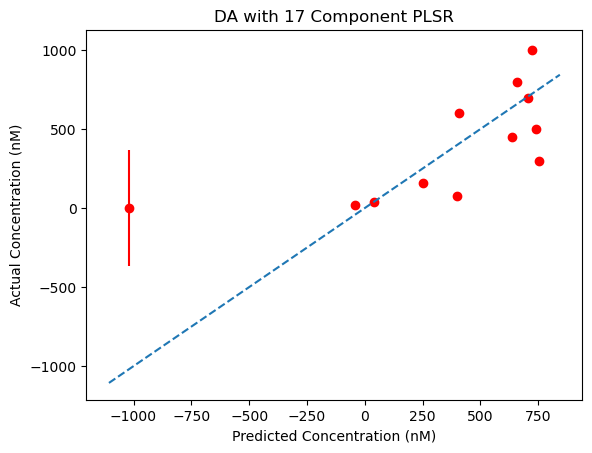

Num comps is 18
R2=0.4339485927995367
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0    -1026.539798         0.0   371.565594
1      -36.556175        20.0    22.134303
2       -0.378359        40.0    21.692467
3      405.610867        80.0    24.716719
4      249.038086       160.0    26.080954
5      831.180146       300.0    22.545026
6      642.605395       450.0    18.281575
7      740.930955       500.0    21.411732
8      410.551831       600.0    21.673756
9      696.497761       700.0    22.626267
10     657.196372       800.0    21.569403
11     703.417652      1000.0    22.830931


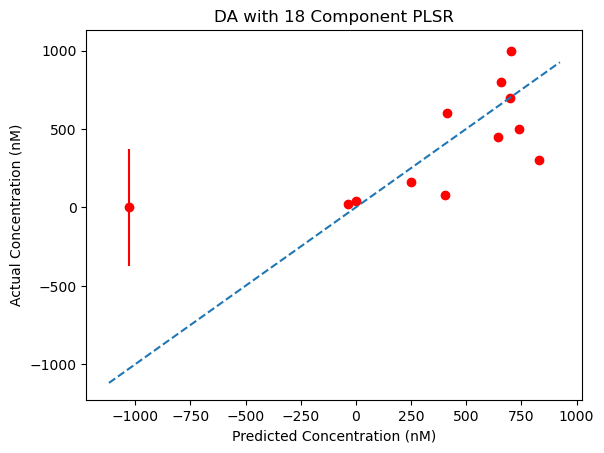

Num comps is 6
R2=-0.030397497562257847
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0      318.123334         0.0   153.710989
1        0.742562        10.0     6.511091
2      101.171369        20.0     8.359932
3      -57.859422        40.0     3.887198
4      125.457552        60.0     4.482163
5       52.116105       120.0     5.292228
6      135.426019       160.0     8.211593
7      200.292782       250.0    16.327815
8      357.535332       300.0    22.386864
9      268.440102       350.0    17.659837
10     281.141671       500.0    10.428655


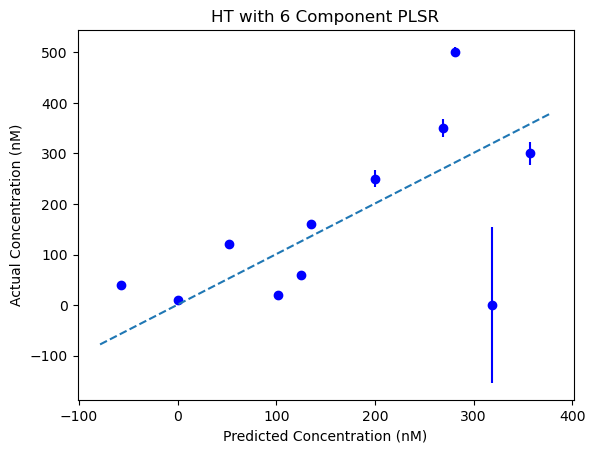

Num comps is 7
R2=-0.016342792320079846
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0      275.113277         0.0   149.647210
1       67.924282        10.0     4.714826
2      122.780233        20.0     5.063042
3      -29.154954        40.0     3.661998
4      119.820732        60.0     4.848774
5      -25.098485       120.0     4.644724
6      162.213904       160.0     5.551361
7      194.580317       250.0    16.224138
8      422.494679       300.0    22.389916
9      257.748129       350.0    15.468432
10     284.226560       500.0     7.571996


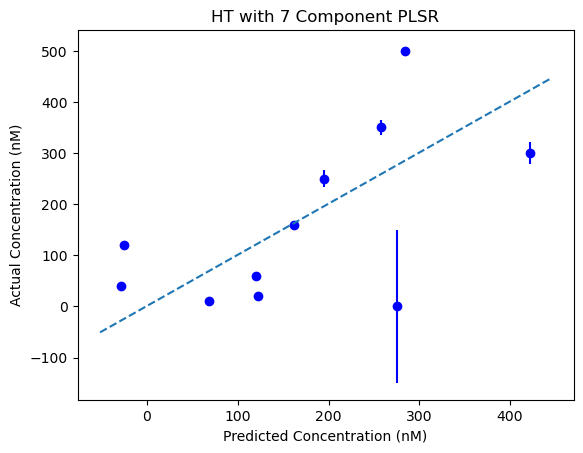

Num comps is 8
R2=0.4920156038370169
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0      222.011485         0.0   165.842123
1       39.557920        10.0    11.446560
2       48.331222        20.0    15.782723
3       22.658889        40.0     4.872770
4       31.892118        60.0     9.713317
5      126.311809       120.0    18.874202
6      207.437220       160.0     9.160637
7      218.673510       250.0    29.742823
8      454.018715       300.0    23.564130
9      300.153502       350.0    23.379597
10     345.558634       500.0    12.910083


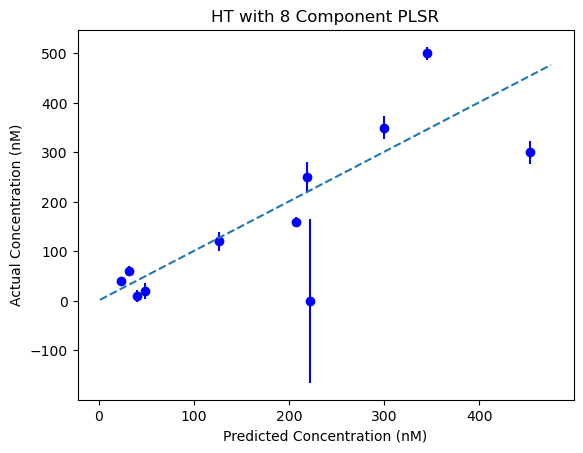

Num comps is 9
R2=0.27362450623474177
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0      337.670813         0.0   197.766096
1       44.853632        10.0    11.851783
2       49.793909        20.0    16.920611
3       35.013801        40.0    11.175262
4       14.478684        60.0    12.887343
5      129.204417       120.0    23.381684
6      153.795759       160.0    13.606275
7      214.032941       250.0    57.495210
8      427.324590       300.0    23.955108
9      316.670762       350.0    23.697899
10     348.157811       500.0    14.233694


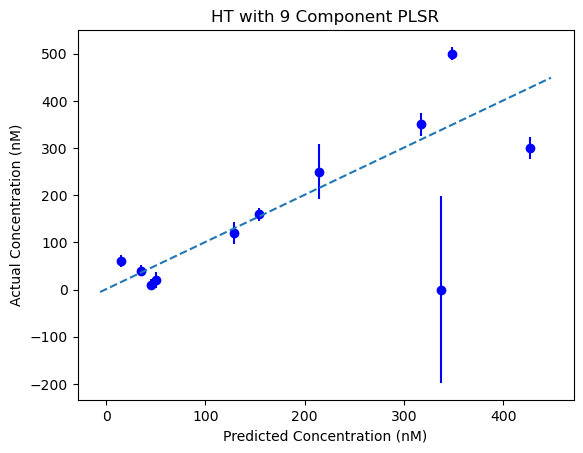

Num comps is 10
R2=0.2787914254710797
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0      354.649405         0.0   222.652834
1       47.381772        10.0     9.622666
2       21.879622        20.0    11.165900
3       69.176154        40.0    10.366142
4       18.479157        60.0    11.873218
5      144.268070       120.0    17.070970
6      140.911401       160.0    11.697801
7      232.179628       250.0    62.748790
8      447.799576       300.0    21.098519
9      324.647740       350.0    19.973006
10     361.384268       500.0    16.114323


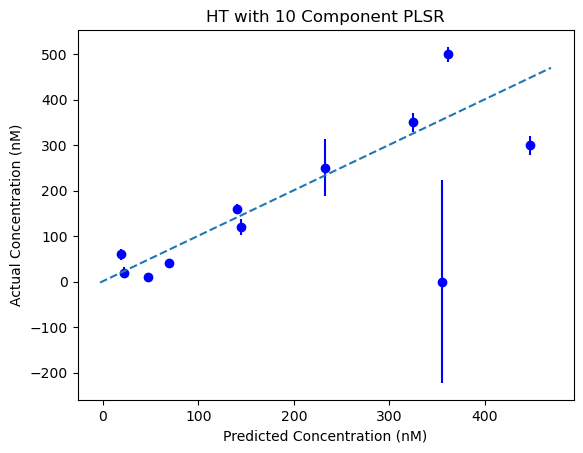

Num comps is 11
R2=0.31116977390954914
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0      304.512889         0.0   215.494418
1       20.299138        10.0    11.030207
2       54.473658        20.0     8.017212
3      107.771186        40.0    15.496451
4       -0.213064        60.0    10.042181
5      187.129227       120.0    15.947536
6      131.186029       160.0    11.182082
7      246.852906       250.0    72.774031
8      461.802459       300.0    19.271864
9      328.304173       350.0    18.690068
10     349.952629       500.0    13.151426


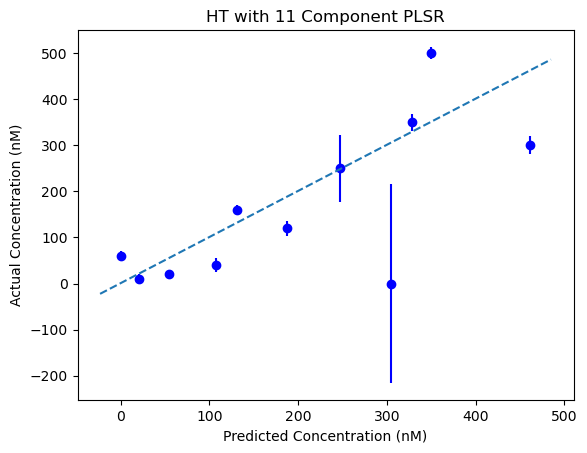

Num comps is 12
R2=0.5874611167598105
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0      117.214035         0.0   190.708095
1        3.509603        10.0    10.767814
2       74.025786        20.0     9.023100
3       73.523300        40.0    10.924734
4        3.411411        60.0    11.395941
5      265.599697       120.0    12.745014
6      176.411181       160.0    13.197443
7      260.082777       250.0    65.368031
8      449.932010       300.0    18.908207
9      321.693055       350.0    19.415827
10     341.504525       500.0     8.941595


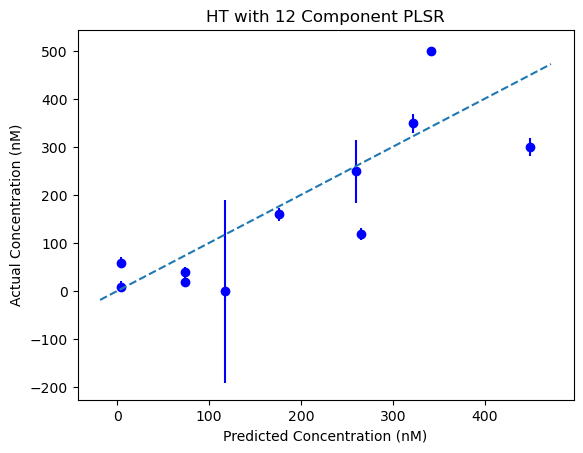

Num comps is 13
R2=0.6030192409449746
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0      100.191437         0.0   154.753820
1       12.993073        10.0    10.225221
2       77.572678        20.0     9.688334
3       66.226214        40.0    10.567731
4       -2.208732        60.0     9.169372
5      282.340544       120.0    17.151928
6      167.160394       160.0    11.139094
7      267.826989       250.0    65.328635
8      449.364465       300.0    16.182582
9      326.699132       350.0    16.625041
10     346.061017       500.0    10.526167


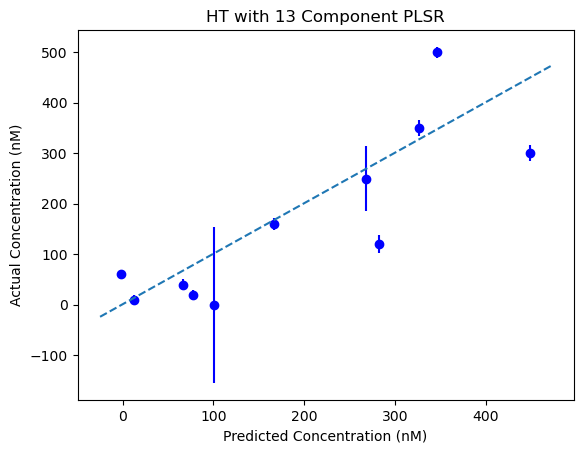

Num comps is 14
R2=0.5869448102444854
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0      101.255018         0.0   156.490593
1        0.048105        10.0    11.375412
2      105.001639        20.0    12.281939
3       55.025518        40.0    13.684299
4       28.312770        60.0    10.724696
5      297.058830       120.0    10.528310
6      154.838079       160.0    13.288708
7      269.972358       250.0    52.217551
8      444.928186       300.0    18.772420
9      343.995353       350.0    19.244356
10     349.287211       500.0    12.988043


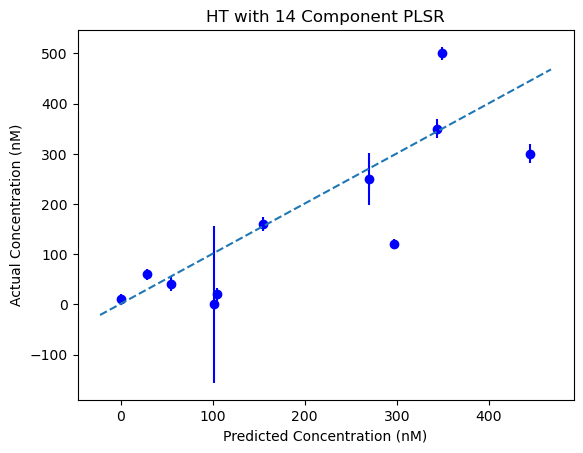

Num comps is 15
R2=0.6094936407362599
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0      143.570472         0.0   159.833448
1       10.164840        10.0    10.339337
2       86.415687        20.0    11.172914
3       49.543980        40.0    12.298164
4       37.487043        60.0    10.535470
5      241.574090       120.0    11.804716
6      159.495492       160.0    12.809115
7      270.112268       250.0    51.569674
8      451.601631       300.0    19.005912
9      340.317518       350.0    17.540112
10     356.160375       500.0    13.402420


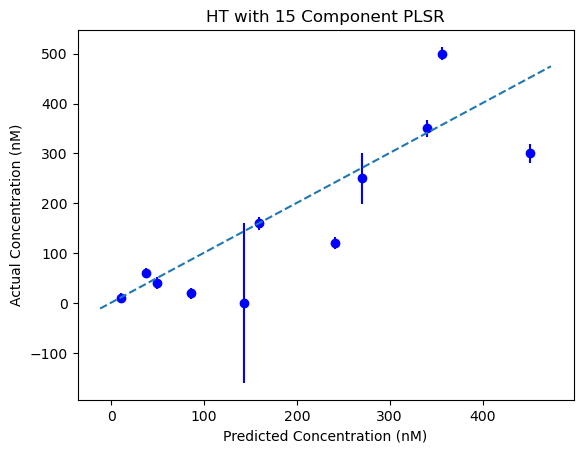

Num comps is 16
R2=0.5955667533980402
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0      130.502879         0.0   164.253778
1      -12.178103        10.0    12.850486
2      110.116768        20.0    13.136600
3       46.398784        40.0    15.438952
4       31.452444        60.0    13.312064
5      267.148723       120.0    13.673593
6      194.608854       160.0    15.182653
7      276.236068       250.0    53.537537
8      447.003322       300.0    19.222810
9      346.758390       350.0    20.091507
10     357.265090       500.0    14.904708


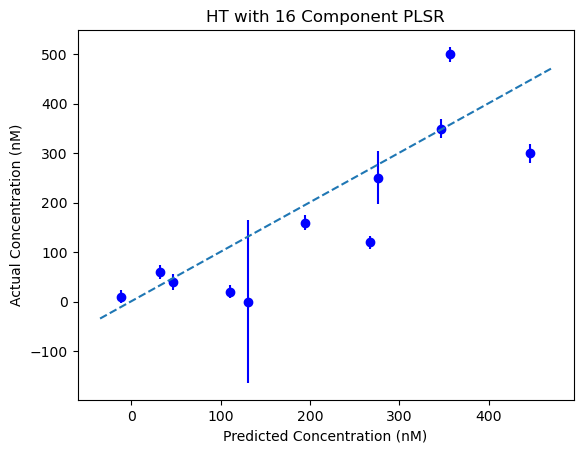

Num comps is 17
R2=0.5263372983463912
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0      130.830310         0.0   170.503784
1      -15.680924        10.0    13.778822
2      107.014423        20.0    12.910485
3       60.476418        40.0    15.516092
4       11.537231        60.0    13.024071
5      335.361423       120.0    16.911645
6      174.829643       160.0    15.215711
7      278.021750       250.0    53.072497
8      449.726036       300.0    18.811823
9      357.874252       350.0    20.361104
10     355.153615       500.0    14.712383


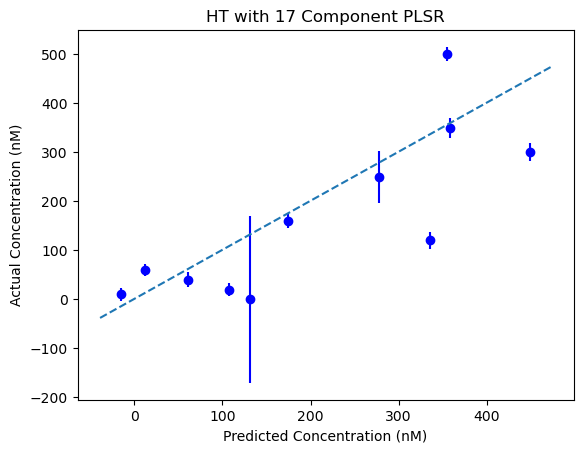

Num comps is 18
R2=0.627909204902531
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0      130.496774         0.0   165.269663
1      -14.831373        10.0    14.414759
2       90.849176        20.0    14.239038
3       58.508652        40.0    15.492994
4       40.712379        60.0    13.646390
5      259.256123       120.0    15.763993
6      181.947079       160.0    15.990346
7      265.129694       250.0    52.660434
8      439.319788       300.0    15.921237
9      356.161335       350.0    18.778229
10     358.400257       500.0    13.807565


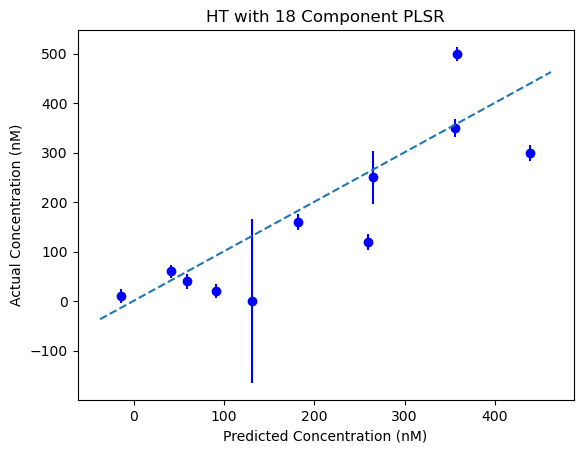

In [29]:
#can run loop to make predictions with range of components if desired 

for analyte in analyte_list:
    for j in np.arange(5,18): #input range of components here if desired
        print("Num comps is "+str(j+1))
        groups = np.array(y_train[analyte]).flatten()

        logo = LeaveOneGroupOut()
        #print(logo.get_n_splits(X_train.T, np.array(y_train).flatten(), groups))

        for i, (train_index, test_index) in enumerate(logo.split(X_train.T, np.array(y_train[analyte]).flatten(), groups)):
            continue 
            #print(f"  Train: index={train_index}, group={groups[train_index]}")
            #print(f"  Test:  index={test_index}, group={groups[test_index]}")
        y_trainCV=np.array(y_train[analyte]).flatten()[train_index]
        y_trainCV=pd.DataFrame(y_trainCV)
        #print(y_trainCV)

        test_pred_avgs=[]
        test_act_avgs = []
        test_pred_std =[]

        for i, (train_index, test_index) in enumerate(logo.split(X_train.T, np.array(y_train[analyte]).flatten(), groups)):
            X_trainCV=X_train.T.iloc[train_index,:]
            X_trainCV=pd.DataFrame(X_trainCV)
            #print(X_trainCV)
            y_trainCV=np.array(y_train[analyte]).flatten()[train_index]
            y_trainCV=pd.DataFrame(y_trainCV)
            #print(y_trainCV)
            X_testCV=X_train.T.iloc[test_index,:]
            X_testCV=pd.DataFrame(X_testCV)
            #print(X_testCV)
            y_testCV=np.array(y_train[analyte]).flatten()[test_index]
            y_testCV=pd.DataFrame(y_testCV)
            #print(y_testCV)
            modelCV = set_model(modelChoice,X_trainCV,y_trainCV,j+1,preprocesser)
            results=modelCV.predict(X_testCV)
            #print(results)
            #print(np.mean(results))
            test_pred_avgs.append(np.mean(results))
            test_act_avgs.append(np.mean(y_testCV.values.tolist()))
            test_pred_std.append(np.std(results))
            #print(np.mean(y_testCV.values.tolist()))
        print('R2='+ str(r2_score(test_pred_avgs,test_act_avgs)))
        table = pd.concat(
            [pd.DataFrame(test_pred_avgs),pd.DataFrame(test_act_avgs),pd.DataFrame(test_pred_std)],
            axis=1,keys=['Predicted (nM)','Actual (nM)', 'Std Dev (nM)'])
        print(table)
        plt.scatter(test_pred_avgs,test_act_avgs,color=cmap[analyte])
        plt.errorbar(test_pred_avgs,test_act_avgs,test_pred_std,fmt='None',color=cmap[analyte])
        plt.xlabel('Predicted Concentration (nM)')
        plt.ylabel('Actual Concentration (nM)')
        plt.title(str(analyte)+' with '+str(j+1)+' Component '+ modelChoice)
        abline(1,1)
        plt.show()
        #print(test_pred_avgs,test_act_avgs,test_pred_std)

Similar to 5-fold CV, ~8 components is best for DA and ~12 is best for ~HT.

# Making Predictions and Calculating Metrics

Let's set up some metrics to measure performance on our test set.

In [50]:
df_testConc=pd.DataFrame({"Actual DA (nM)": y_test['DA'],"Actual 5HT (nM)": y_test['HT']})

actualDA = df_testConc['Actual DA (nM)'].to_numpy()
actualHT = df_testConc['Actual 5HT (nM)'].to_numpy()


In [45]:
df_metrics = pd.DataFrame({'N Comps': [],'MAE DA 0-T4':[],'MAE 5HT 0-T4':[],
                          })

We'll need to define a scan interval. Meaning, how many voltammograms were extracted from each injection?

Remember, we extracted 51 voltammograms/injection, as defined in the very top of this notebook. 

This is important to define correctly, as it will define how the metrics are calculated and plotted.

In [46]:
scanInterval = 51

By cross validation, we would've chosen ~8 components for DA and ~12 components for HT.

Let's see how the test data performs across this.

Note- you should not choose your number of components by fitting the test data. You should do so using cross validation. Choosing the components that fit the test data best is likely to overfit the test data! We are just peeking for demonstration purposes.

Running 7 component model...
                   DA                  HT
0  0.9257242615228438                 NaN
1                 NaN  0.6348289891599892


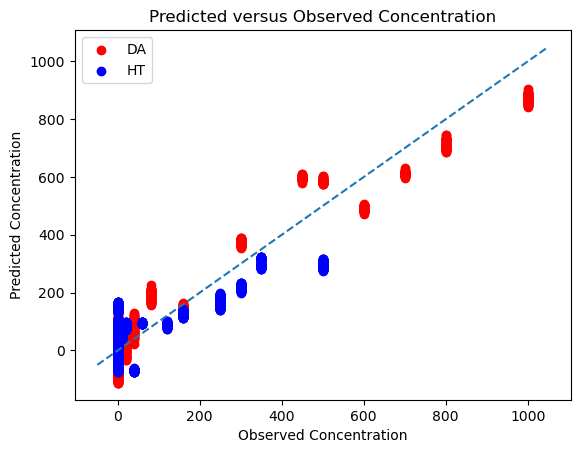

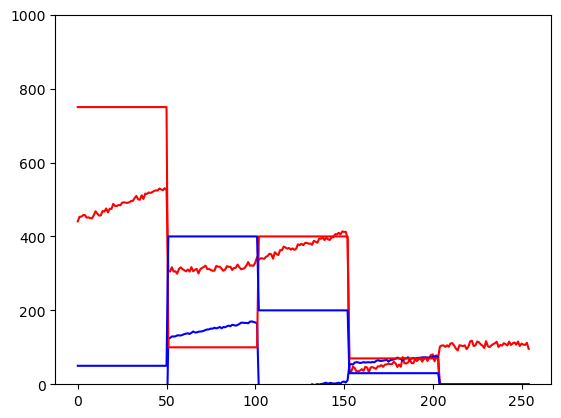

                   DA                    HT
0  0.6708651000160681                   NaN
1                 NaN  -0.36577494979232683
DA test prediction correlation: 0.6709
5HT test prediction correlation: -0.3658


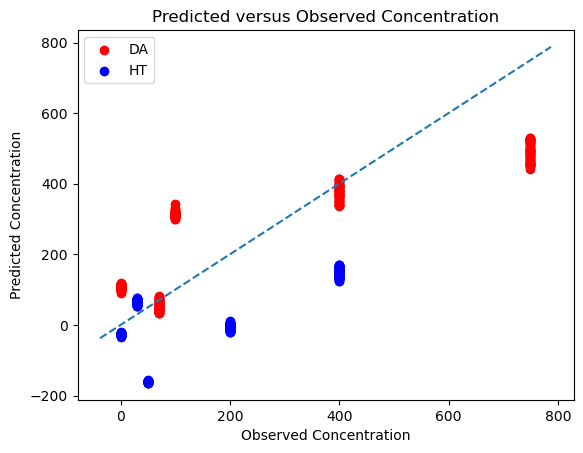

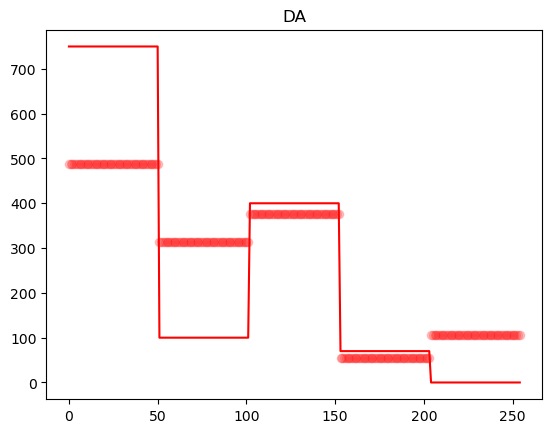

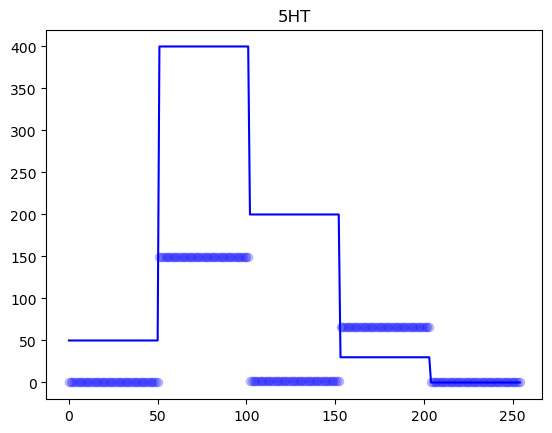

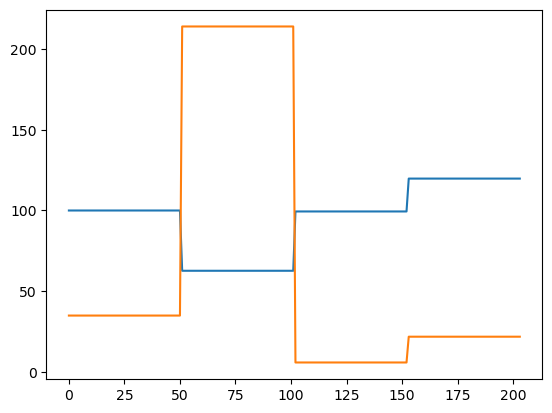

Running 8 component model...
                   DA                  HT
0  0.9500515504469386                 NaN
1                 NaN  0.6954196751260304


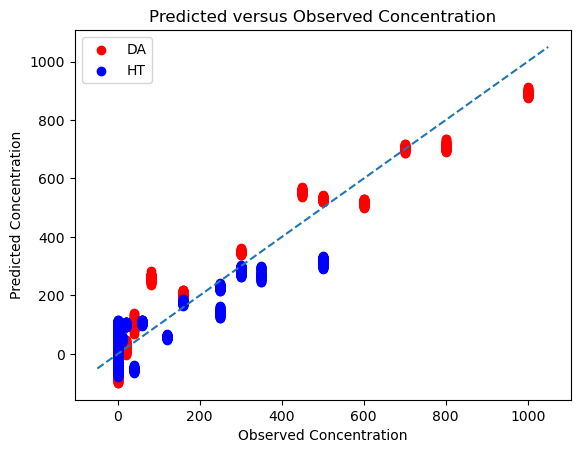

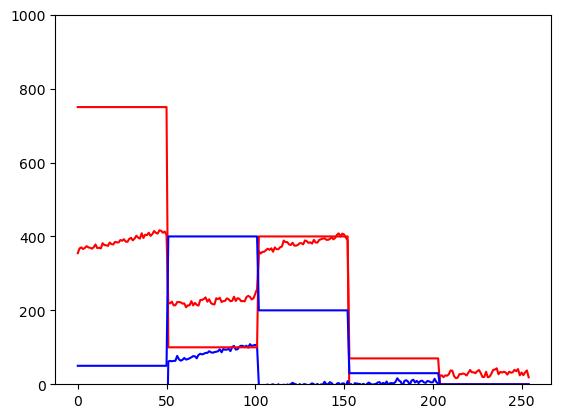

                   DA                   HT
0  0.5916866034254405                  NaN
1                 NaN  -1.0445197927874381
DA test prediction correlation: 0.5917
5HT test prediction correlation: -1.0445


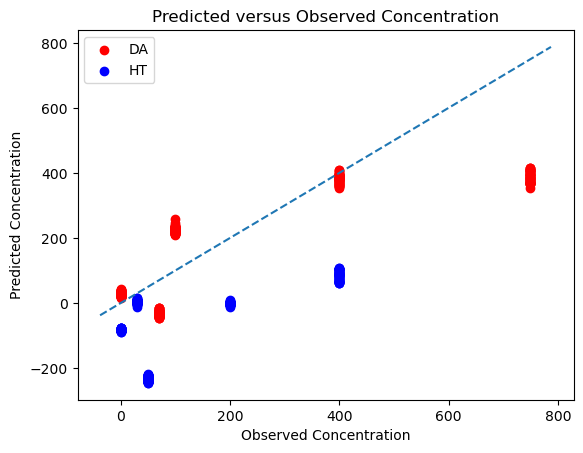

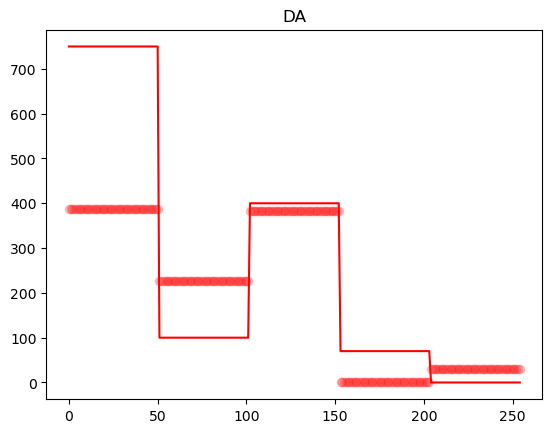

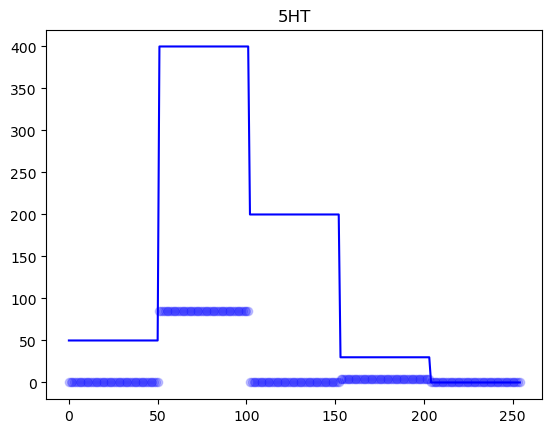

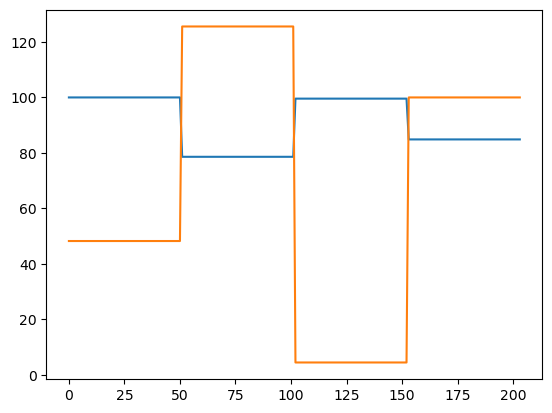

Running 9 component model...
                   DA                  HT
0  0.9519516240313751                 NaN
1                 NaN  0.9290756375750144


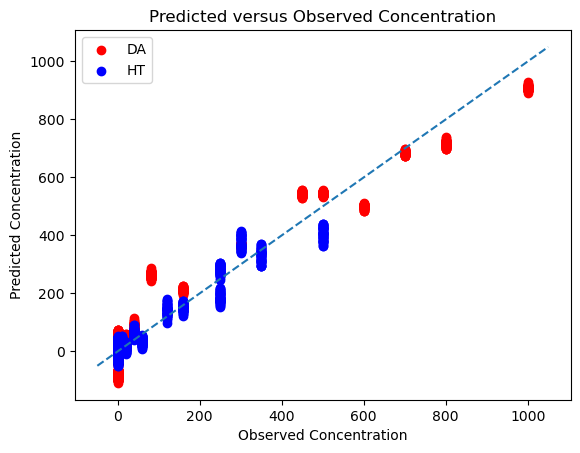

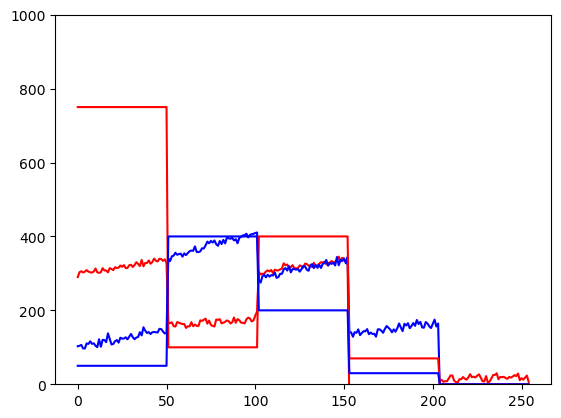

                   DA                  HT
0  0.4458101195535997                 NaN
1                 NaN  0.6861177508468345
DA test prediction correlation: 0.4458
5HT test prediction correlation: 0.6861


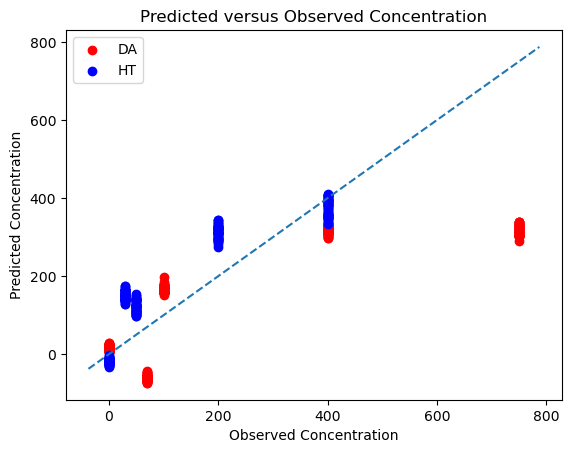

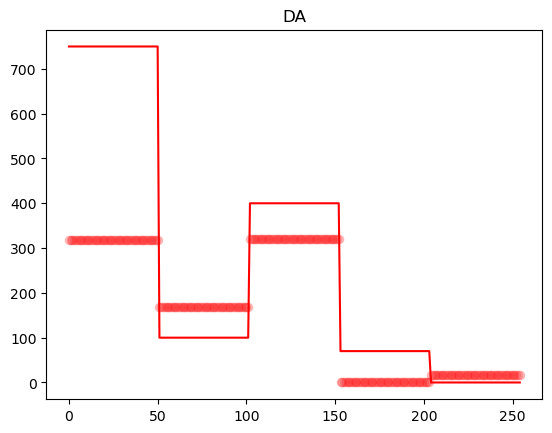

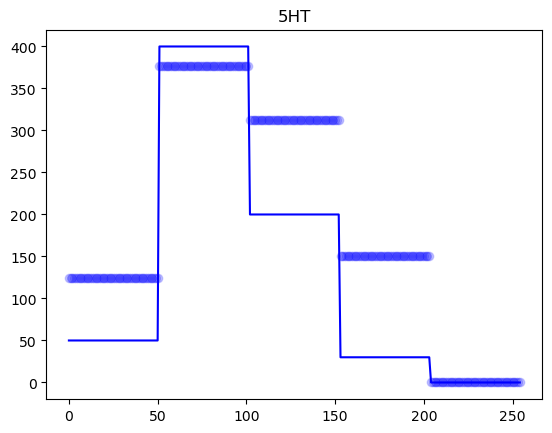

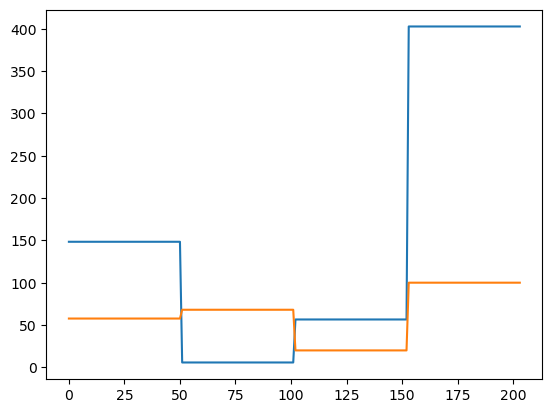

Running 10 component model...
                   DA                  HT
0  0.9624161185100336                 NaN
1                 NaN  0.9290765223143413


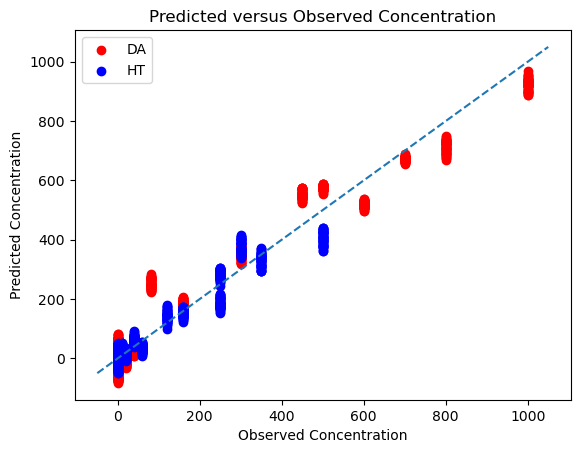

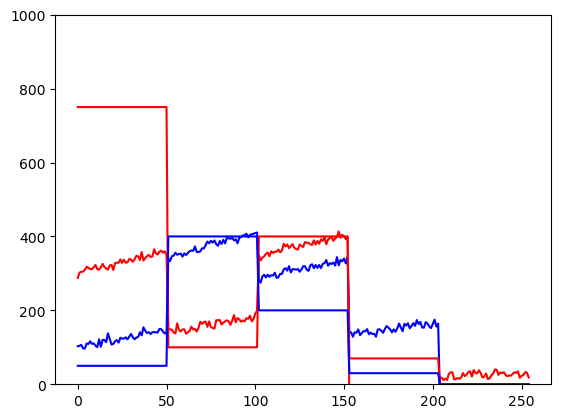

                   DA                 HT
0  0.5016856963146412                NaN
1                 NaN  0.686898684788711
DA test prediction correlation: 0.5017
5HT test prediction correlation: 0.6869


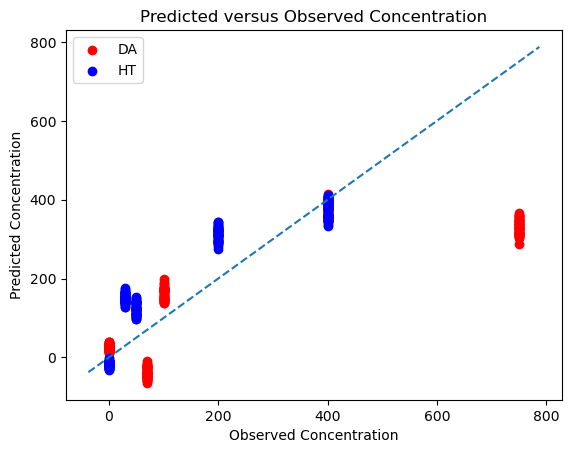

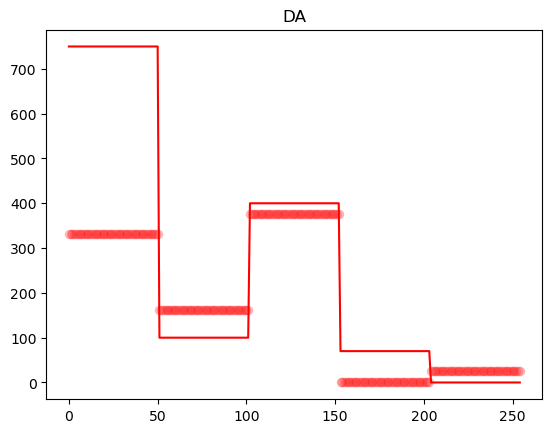

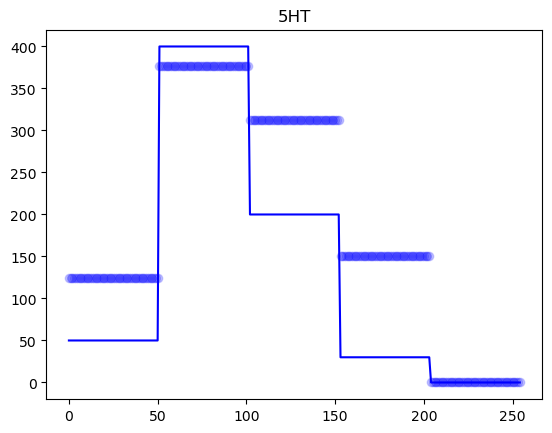

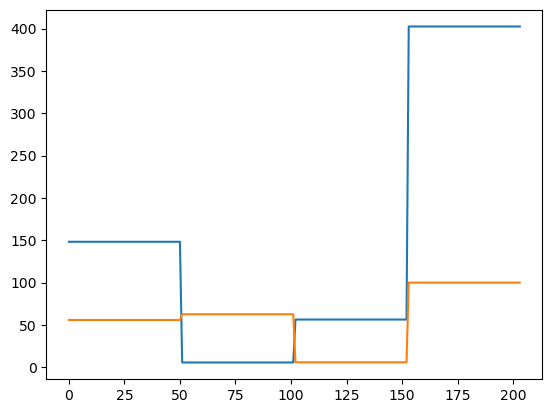

Running 11 component model...
                   DA                  HT
0  0.9662624328335242                 NaN
1                 NaN  0.9290790080021232


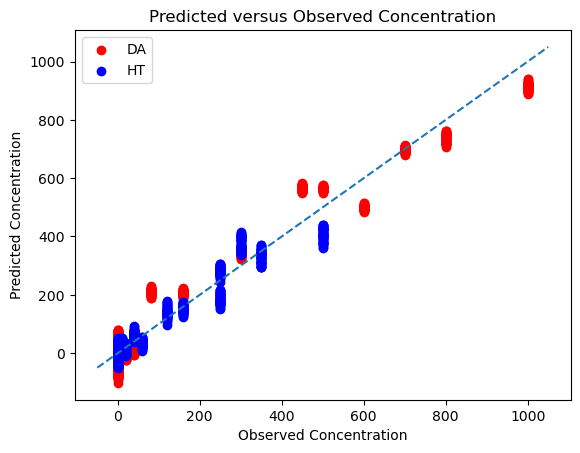

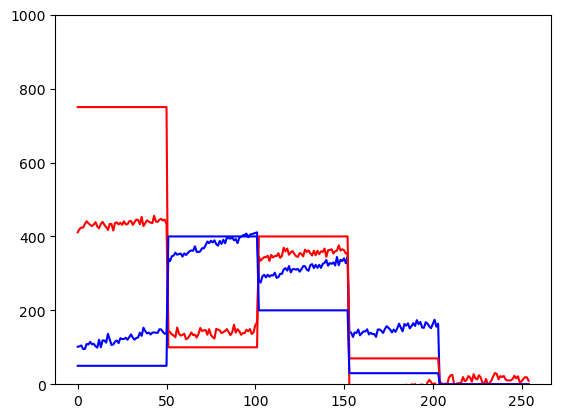

                  DA                 HT
0  0.717526535708207                NaN
1                NaN  0.688742769901981
DA test prediction correlation: 0.7175
5HT test prediction correlation: 0.6887


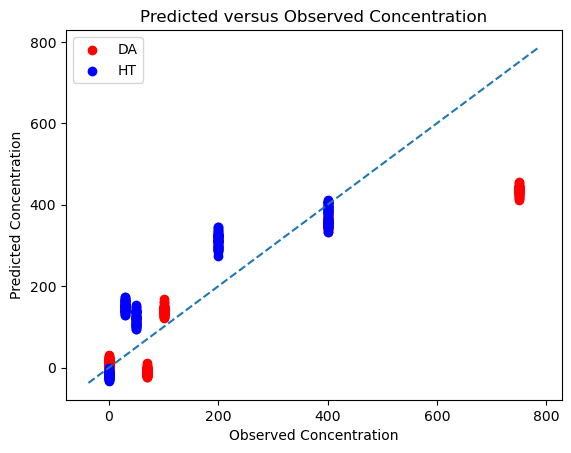

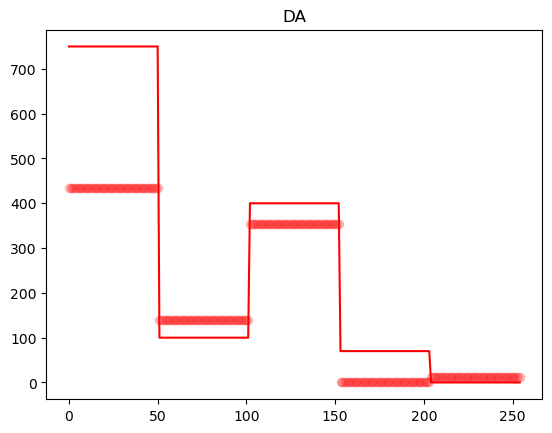

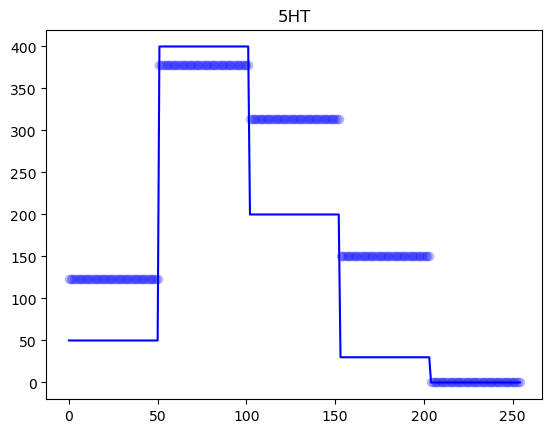

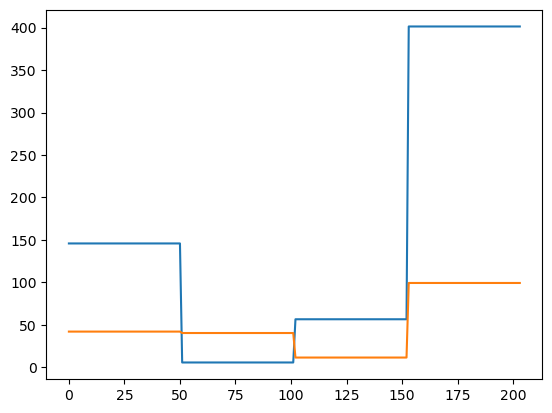

Running 12 component model...
                   DA                  HT
0  0.9688561141222016                 NaN
1                 NaN  0.9385593223943419


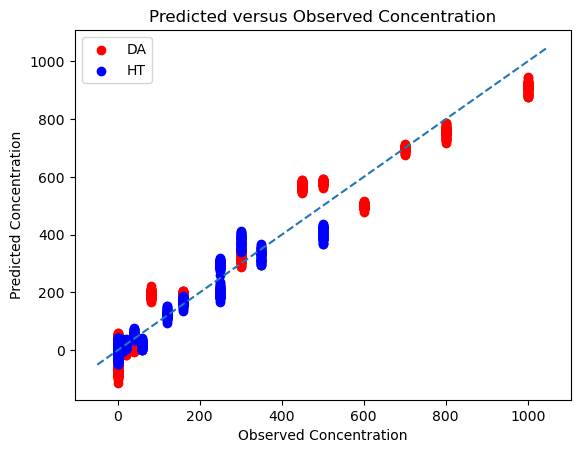

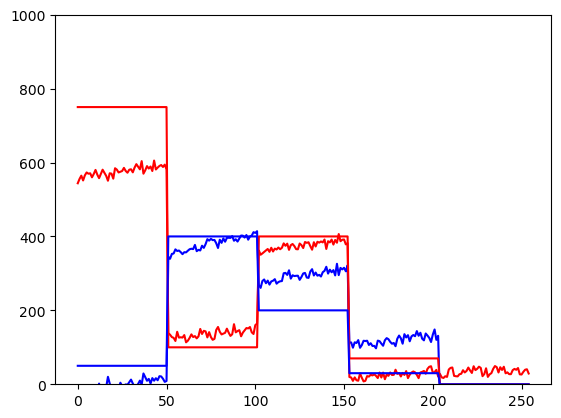

                   DA                  HT
0  0.9077198026291967                 NaN
1                 NaN  0.8009711214759838
DA test prediction correlation: 0.9077
5HT test prediction correlation: 0.801


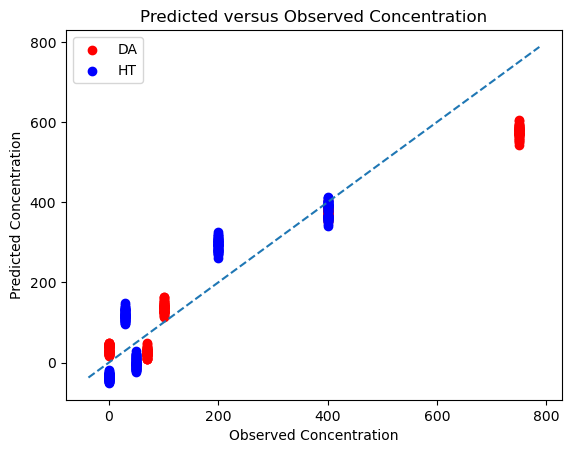

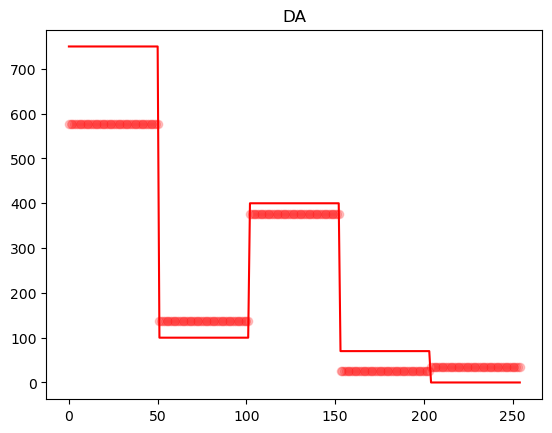

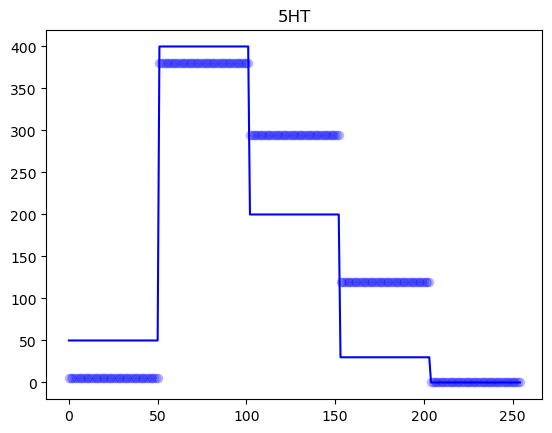

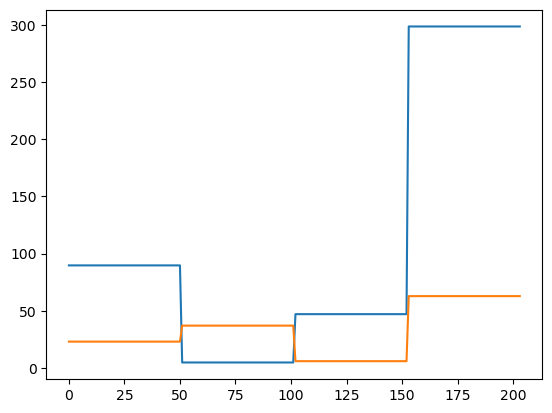

Running 13 component model...
                   DA                  HT
0  0.9721433132258243                 NaN
1                 NaN  0.9386675495252914


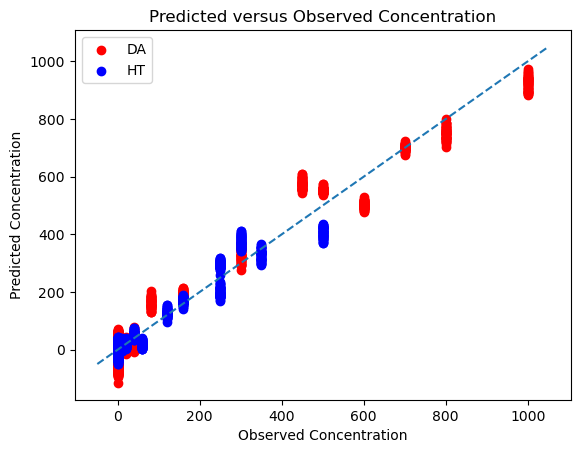

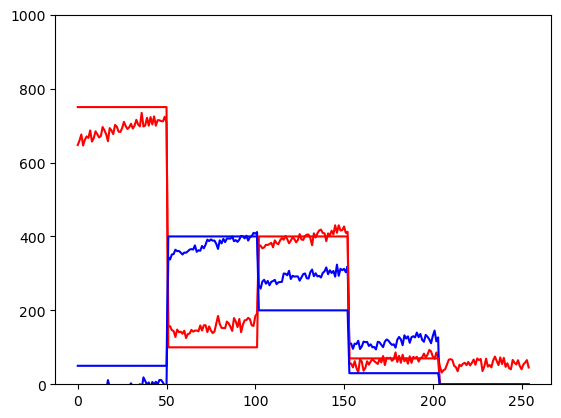

                   DA                  HT
0  0.9725964226650172                 NaN
1                 NaN  0.7981857105897987
DA test prediction correlation: 0.9726
5HT test prediction correlation: 0.7982


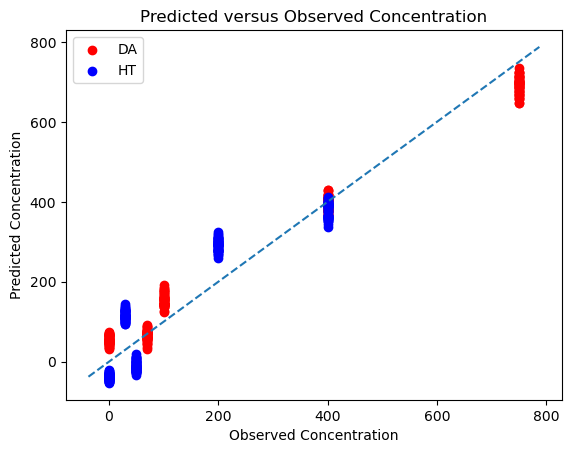

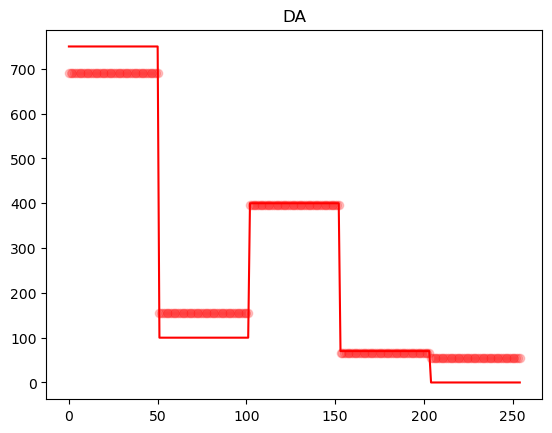

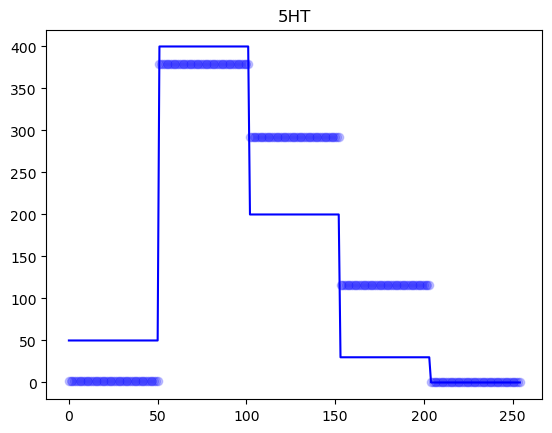

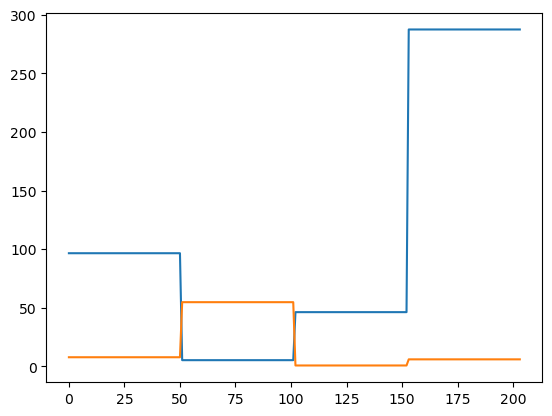

Running 14 component model...
                  DA                  HT
0  0.978741334335058                 NaN
1                NaN  0.9388130633669436


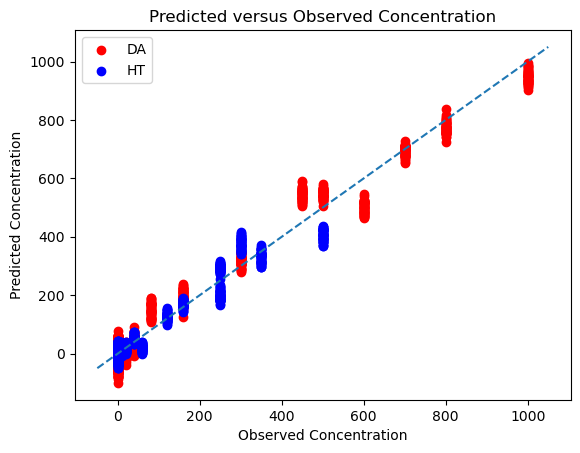

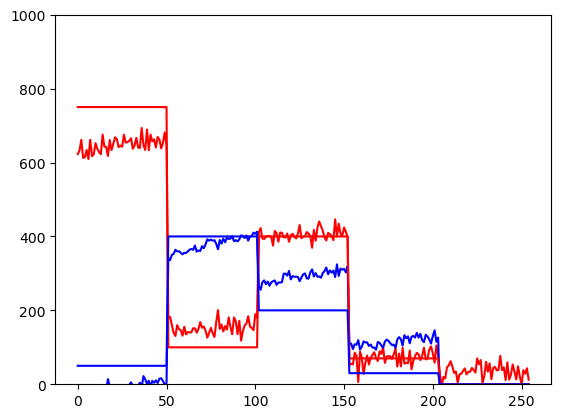

                   DA                  HT
0  0.9582584852807181                 NaN
1                 NaN  0.8032142374222421
DA test prediction correlation: 0.9583
5HT test prediction correlation: 0.8032


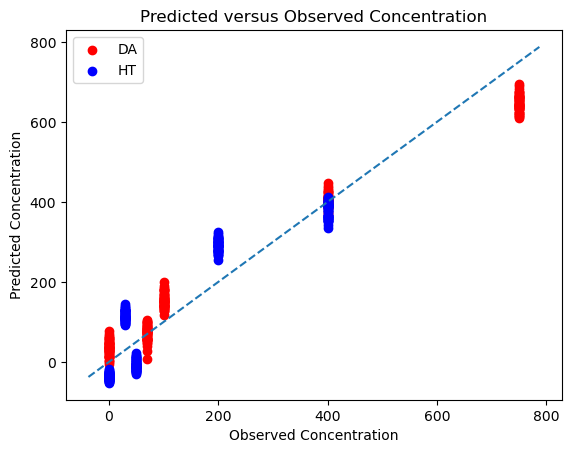

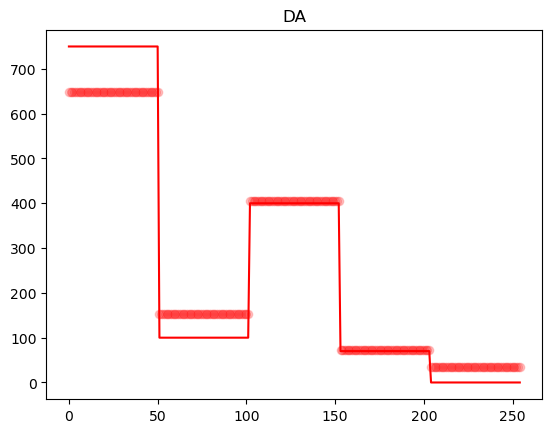

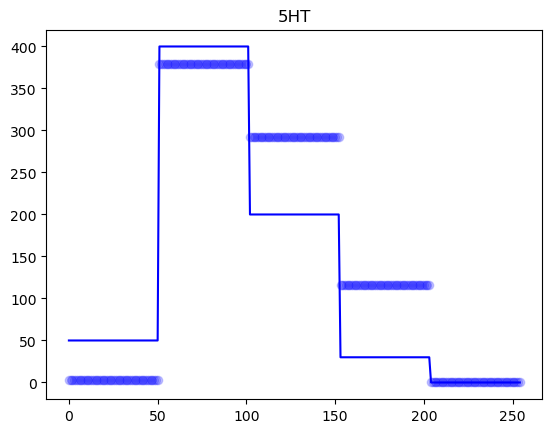

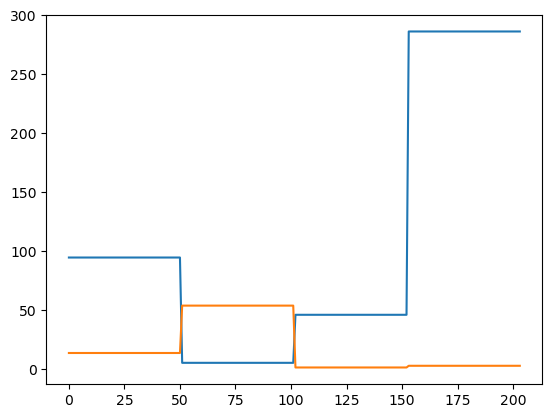

Running 15 component model...
                 DA                  HT
0  0.97874163173255                 NaN
1               NaN  0.9550854361745875


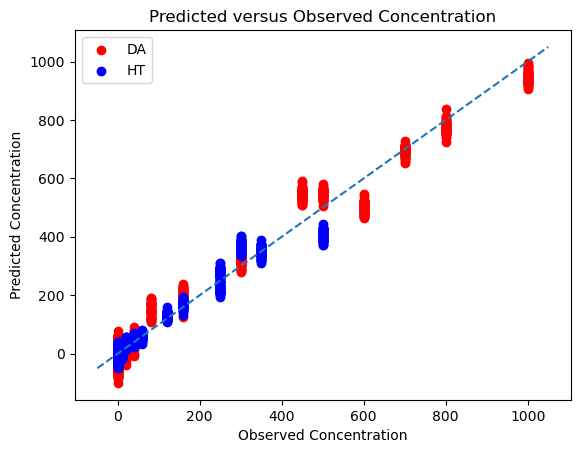

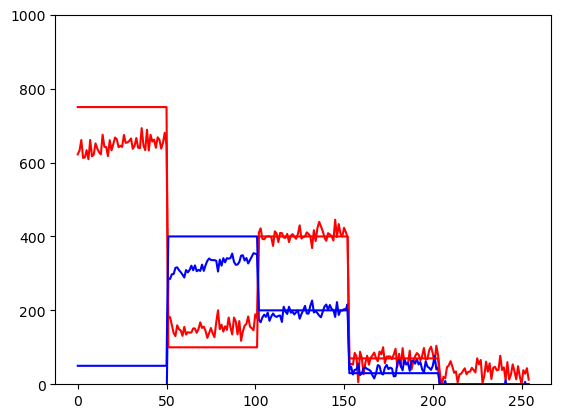

                   DA                  HT
0  0.9581181812857542                 NaN
1                 NaN  0.8172472715776876
DA test prediction correlation: 0.9581
5HT test prediction correlation: 0.8172


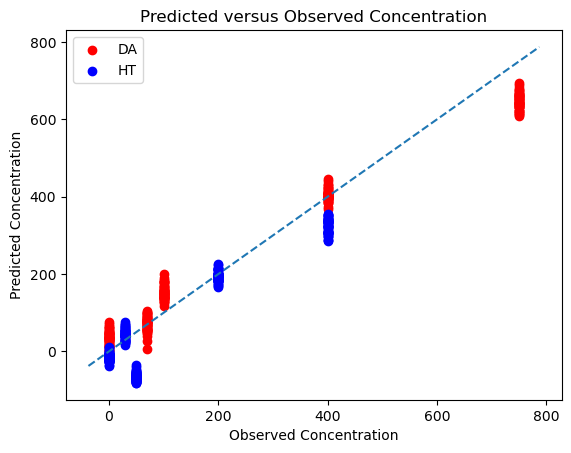

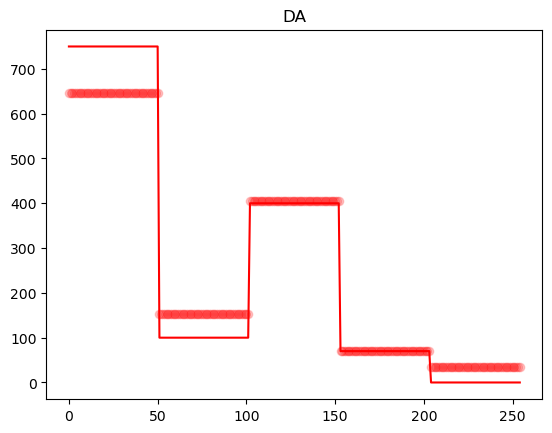

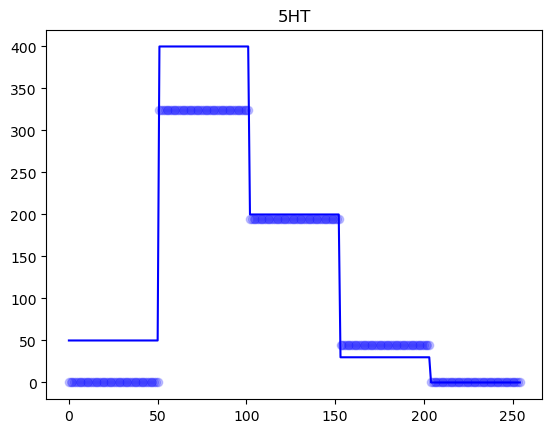

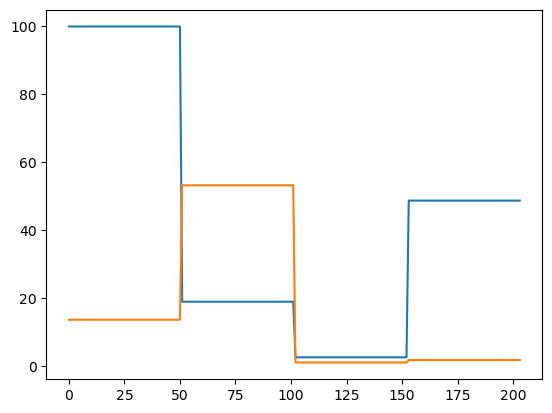

Analysis Complete!
   N Comps  MAE DA 0-T4  MAE 5HT 0-T4
0      7.0   125.098795    107.086328
1      8.0   121.168756    117.803042
2      9.0   133.370337     66.581718
3     10.0   120.374993     66.499488
4     11.0    96.729020     66.214267
5     12.0    62.753325     50.075016
6     13.0    38.436143     49.934084
7     14.0    43.578547     49.562955
8     15.0    43.559507     30.965058


In [47]:
finalComps=[7,8,9,10,11,12,13,14,15]
entry=0
for i in finalComps:
    
    df_metrics.at[entry,'N Comps']=i
    print('Running ' + str(i) + ' component model...')
    
    model = set_model(modelChoice,X_train.T,y_train,i,preprocesser)
    calibration_curves(model,X_train.T,y_train,analyte_list,cmap)
    plt.show()
    #vip(model)
    #plt.show()
    results = model.predict(X_test.T)
    df_results=pd.DataFrame({"Predicted DA (nM)": np.round(results[:,0],4),
                             "Predicted 5HT (nM)": np.round(results[:,1],4)})
    
    predDA = df_results['Predicted DA (nM)'].to_numpy()
    predHT = df_results['Predicted 5HT (nM)'].to_numpy()
    
    predDA[predDA < 0] = 0
    predHT[predHT < 0] = 0
    
    plt.plot(results[:,0],label='DA',color='r');
    plt.plot(results[:,1],label='HT',color='b');
    plt.plot(range(len(y_test.iloc[:,0])),y_test.iloc[:,0],color='r',label='DA')
    plt.plot(range(len(y_test.iloc[:,1])),y_test.iloc[:,1],color='b',label='HT')
    plt.ylim([0,1000])
    plt.show()
    calibration_curves(model,X_test.T,y_test,analyte_list,cmap)
    print('DA test prediction correlation: '+ str(np.round(r2_score(y_test.iloc[:,0],results[:,0]),4)))
    print('5HT test prediction correlation: '+ str(np.round(r2_score(y_test.iloc[:,1],results[:,1]),4)))
    
    plt.show()
    
    #create variable of same size
    avgDA=np.full_like(predDA,0)
    avgHT=np.full_like(predHT,0)
    
    #fill variable with average prediction 
    for m in range(int(len(df_results)/scanInterval)):
        avgDA[m*scanInterval:(m+1)*scanInterval]=(np.mean(predDA[m*scanInterval:(m+1)*scanInterval]))
        avgHT[m*scanInterval:(m+1)*scanInterval]=(np.mean(predHT[m*scanInterval:(m+1)*scanInterval]))
    
    #fill variable with absolute error  
    errorDA=np.absolute(predDA-actualDA)
    errorHT=np.absolute(predHT-actualHT)
    
    #plot and print DA predictions/averages/errors
    plt.scatter(range(len(avgDA)),avgDA,color='r',alpha=0.2)
    plt.plot(actualDA,color='r')
    plt.title('DA')
    plt.show()
    
    df_metrics.at[entry,'MAE DA 0-T4']=np.mean(errorDA[:5*scanInterval])
              
    #plot and print 5HT predictions/averages/errors
    plt.scatter(range(len(avgHT)),avgHT,color='b',alpha=0.2)
    plt.plot(actualHT,color='b')
    plt.title('5HT')
    plt.show()
    
    plt.plot(abs((avgHT-actualHT)/actualHT)*100)
    plt.plot(abs((avgDA-actualDA)/actualDA)*100)
    plt.show()

    df_metrics.at[entry,'MAE 5HT 0-T4']=np.mean(errorHT[:5*scanInterval])
    
    entry+=1
    
print("Analysis Complete!")
print(df_metrics)

Interestingly, the 13 and 15 component models performed best for predicting DA and HT test samples, respectively. 

While we may have chosen a 15 component model for 5-HT based on the ambigious elbow point, we probably would not have chosen a 13 component model for DA. Testing and interpreting different cross validation approaches is important.

Lastly, this was all data using a randomly generated waveform. Put in perspective, this performance isn't too shabby!

In [48]:
df_metrics

N Comps  MAE DA 0-T4  MAE 5HT 0-T4
0      7.0   125.098795    107.086328
1      8.0   121.168756    117.803042
2      9.0   133.370337     66.581718
3     10.0   120.374993     66.499488
4     11.0    96.729020     66.214267
5     12.0    62.753325     50.075016
6     13.0    38.436143     49.934084
7     14.0    43.578547     49.562955
8     15.0    43.559507     30.965058

These results will be useful for our Bayesian optimization notebook.

# Saving the Model

We've put a lot of work and time into training, validating and test this model. When we close this notebook, we don't want to lose all that progress, of else we will have to retrain our model everytime.

To save our model, we can do the following. Note that the last model ran (15 components above) will be the one saved, unless you set the model as something else.

In [54]:
def save_model(myModel,myFile):
    """"""
    pickle.dump(myModel, open(myFile, 'wb'))
    print('Saved model successfully!')
    
def load_model(myFile):
    ''''''
    file = open(myFile, 'rb')
    myModel = pickle.load(file)
    return myModel

In [55]:
save_model(model,'name_your_model_here')

Saved model successfully!


Then, next time you want to run this model, you can skip all the above steps and simply load the previous model.

In [56]:
loaded_model = load_model('name_your_model_here')

In [57]:
print(loaded_model)

Pipeline(steps=[('normalizer', Normalizer(norm='max')),
                ('plsregression', PLSRegression(n_components=15, scale=False))])


In [58]:
loaded_model.predict(X_test.T)

array([[ 6.22249060e+02, -6.27391604e+01],
       [ 6.32298861e+02, -6.59940638e+01],
       [ 6.60809501e+02, -7.69199112e+01],
       [ 6.12288641e+02, -5.95564217e+01],
       [ 6.13980841e+02, -7.47831706e+01],
       [ 6.33641678e+02, -6.06679278e+01],
       [ 6.08919759e+02, -6.29085549e+01],
       [ 6.61050538e+02, -6.95417592e+01],
       [ 6.16797314e+02, -6.44462020e+01],
       [ 6.21328399e+02, -5.67708503e+01],
       [ 6.51842560e+02, -8.14444927e+01],
       [ 6.37398796e+02, -8.13872087e+01],
       [ 6.28040660e+02, -4.74841764e+01],
       [ 6.22032326e+02, -7.45972578e+01],
       [ 6.75160940e+02, -6.38935531e+01],
       [ 6.42349303e+02, -6.32272133e+01],
       [ 6.42060142e+02, -7.36401933e+01],
       [ 6.17303110e+02, -3.63094156e+01],
       [ 6.60378708e+02, -5.81632550e+01],
       [ 6.32961171e+02, -7.89381843e+01],
       [ 6.49507592e+02, -8.03472880e+01],
       [ 6.67654256e+02, -7.94508068e+01],
       [ 6.62828431e+02, -6.88516878e+01],
       [ 6.

# Model Interpretation 

You can also look at the variable importance in projection (VIP) scores if you use a PLSR model.

These help discern where the most important points in the voltammograms come from.

Text(0.5, 1.0, 'Total VIP Scores')

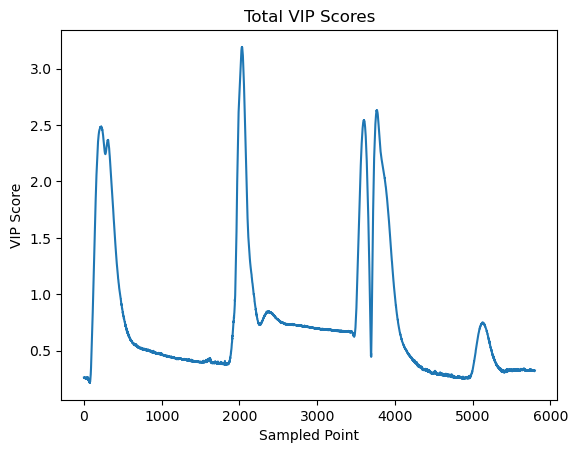

In [59]:
vip(model)
plt.title('Total VIP Scores')

We can also plot our waveform. The parameters are in vector form by E1, t1, E2, t2, E3, E4.

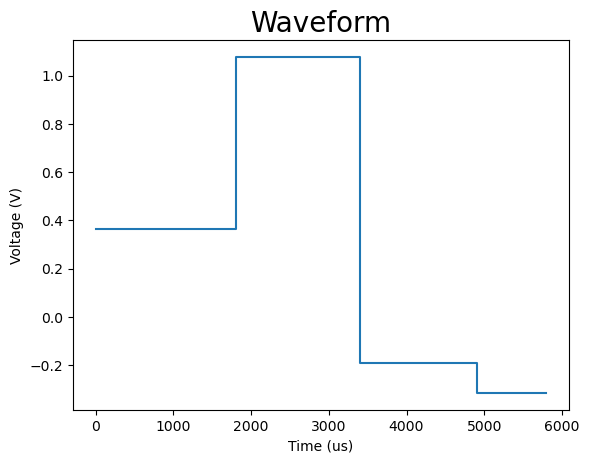

In [53]:
waveform= [[0.363,1.8,1.077,1.6,-0.192,1.5,-0.314,0.9]]


for i in waveform:
    x_plt = [0,i[1],i[1],i[3]+i[1],i[3]+i[1],i[3]+i[1]+i[5],
         i[3]+i[1]+i[5],i[3]+i[1]+i[5]+i[7]]
    y_plt = [i[0],i[0],i[2],i[2],i[4],i[4],i[6],i[6]]
    x_plt = [element*1000 for element in x_plt]
    plt.plot(x_plt,y_plt);
    # setting title
    plt.title("Waveform", fontsize=20)
    # setting x-axis label and y-axis label
    plt.xlabel("Time (us)")
    plt.ylabel("Voltage (V)")
    plt.show()

To look at the loadings or coefficients of the PLSR model, you can plot them as such.

Similar plots can be built for PCR models. 

Text(0.5, 1.0, 'PLSR X-Loadings by Analyte')

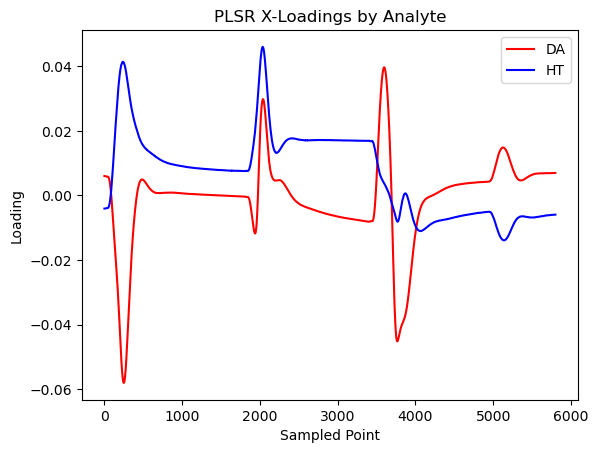

In [61]:
plt.plot((loaded_model.named_steps['plsregression'].x_loadings_)[:,0],color='r',label='DA')
plt.plot((loaded_model.named_steps['plsregression'].x_loadings_)[:,1],color='b',label='HT')
plt.legend()
plt.xlabel('Sampled Point')
plt.ylabel('Loading')
plt.title('PLSR X-Loadings by Analyte')

Text(0.5, 1.0, 'PLS Regression Coefficients by Analyte')

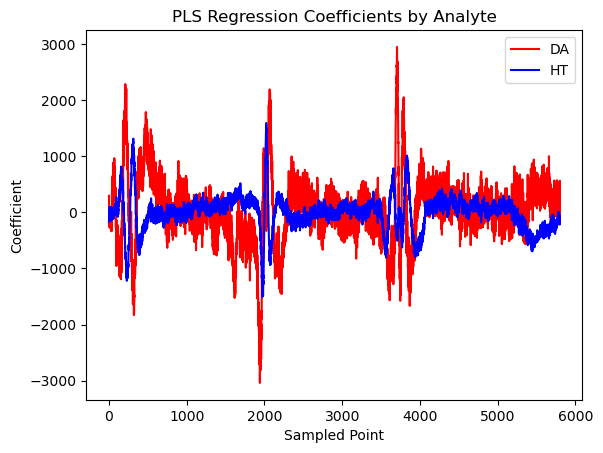

In [58]:
plt.plot((loaded_model.named_steps['plsregression'].coef_)[:,0],label='DA',color='r')
plt.plot((loaded_model.named_steps['plsregression'].coef_)[:,1],label='HT',color='b')
plt.legend()
plt.xlabel('Sampled Point')
plt.ylabel('Coefficient')
plt.title('PLS Regression Coefficients by Analyte')

If we want to visualize the individual VIP scores by analyte, we can augment the VIP function as such.

In [50]:
def vip_by_analyte(model,y_index):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_[y_index,:]
    q = np.reshape(q,(1,-1))
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)
    return vips

Text(0.5, 1.0, 'VIP Scores by Analyte')

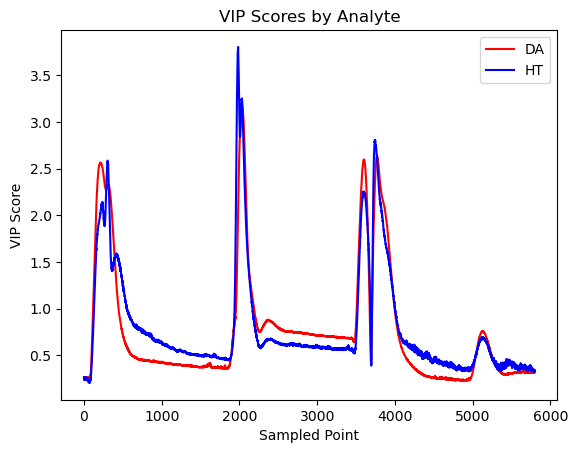

In [57]:
plt.plot(vip_by_analyte(loaded_model.named_steps['plsregression'],0),color='r',label='DA')
plt.plot(vip_by_analyte(loaded_model.named_steps['plsregression'],1),color='b',label='HT')
plt.legend()
plt.xlabel('Sampled Point')
plt.ylabel('VIP Score')
plt.title('VIP Scores by Analyte')

Sometimes it may be useful to reconstruct the voltammograms from the retained components. For example, some validation techniques look at reconstruction error.

In [68]:
##under development##
#TODO: incorporate pipeline
def reconstruct_voltammograms(myX,myY,modelChoice,nComponents,preProcesser, preProcess):
    if modelChoice == 'PCR':
        pca = PCA(n_components=nComponents);
        myX_reduced = pca.fit_transform(myX);
        myX_recovered = pca.inverse_transform(myX_reduced);

    if modelChoice == 'PLSR':
        plsr = PLSRegression(n_components=nComponents,scale=False);
        myX_reduced = plsr.fit_transform(myX,myY);
        myX_recovered = plsr.inverse_transform(plsr.x_scores_);

    plt.plot(myX.T);
    plt.xlabel('Sample')
    plt.ylabel('Preprocessed Current (nA)')
    plt.title('Preprocessed Voltammogram')
    plt.show();
    plt.plot((myX_recovered).T);
    plt.xlabel('Sample')
    plt.ylabel('Preprocessed Current (nA)')
    plt.title('Reconstructed Preprocessed Voltammogram')
    plt.show()

    if preProcess != 'Normalize Samples':
        plt.plot((preProcesser.inverse_transform(myX)).T);
        plt.xlabel('Sample')
        plt.ylabel('Current (nA)')
        plt.title('Voltammogram')
        plt.show();
        plt.plot((preProcesser.inverse_transform(myX_recovered)).T);
        plt.xlabel('Sample')
        plt.ylabel('Current (nA)')
        plt.title('Reconstructed Voltammogram')
        plt.show()

    print("Reconstruction Error (%):", 100*round(1-r2_score(myX,myX_recovered),4))

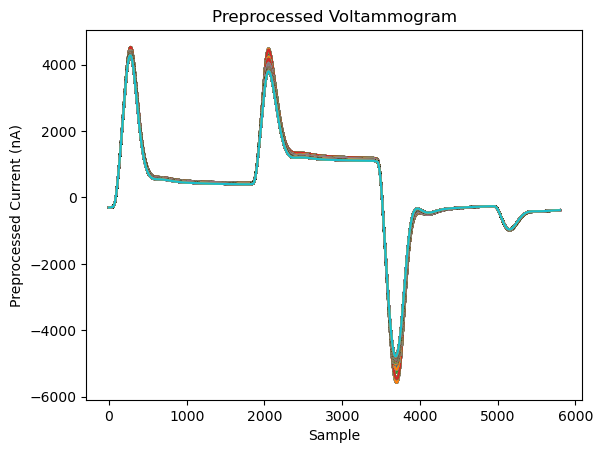

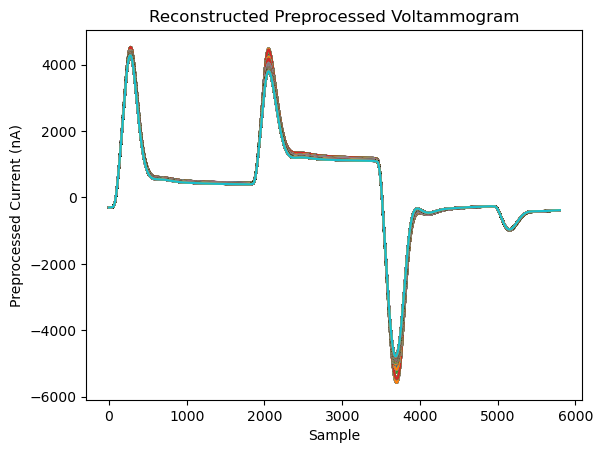

Reconstruction Error (%): 1.31


In [69]:
reconstruct_voltammograms(X_train.T,y_train,'PLSR',15,preprocesser,'Normalize Samples')